**Заголовок:** 
Предсказание уровня удовлетворённости и веротяности увольнения сотрудника из компании

**Описание проекта:** 

Некоторая компания предоставила данные с характеристиками своих сотрудников. 
Среди них — уровень удовлетворённости сотрудника работой в компании и данные об оттоке сотрудников.
Для бизнеса это важнейшие характеристики - удовлетворённость работой напрямую влияет на отток сотрудников, а отток (т.е. внезапные увольнения) несёт в себе риски для компании, особенно если уходит важный сотрудник.
Уровень удовлетворённости и вероятность увольнения и являтся целевыми переменными, а **цель исследования** - разработать модели для их предсказания.


**Задачи**

Разработать две модели для предсказания:
1. уровня удовлетворённости сотрудника
1. вероятности увольнения сотрудника из компании

**Ход исследования:** 

*Задача 1:*
- Загрузка данных. Три файла:
	- Тренировочная выборка: `train_job_satisfaction_rate.csv`
	- Входные признаки тестовой выборки: `test_features.csv`
	- Целевой признак тестовой выборки: `test_target_job_satisfaction_rate.csv`

- Предобработка данных. Изучить данные, сделать выводы, при необходимости выполнить предобработку. **Если есть пропуски, заполнить их в пайплайне.**

- Исследовательский анализ данных. Исследовать все признаки и сделать выводы о том, как их нужно подготовить.

- Подготовка данных. Подготовку признаков выполнить в пайплайне, дополнив пайплайн шагом предобработки. При кодировании учитывать особенности признаков и моделей и использовать как минимум два кодировщика.

- Обучение моделей. Обучить как минимум две модели (линейную модель и дерево решений). Подобрать гиперпараметры как минимум для одной модели. Выберите лучшую модель на основе метрики SMAPE и использовать эту метрику при подборе гиперпараметров и оценке качества моделей. Критерий успеха: SMAPE ≤15 на тестовой выборке.

- Оформление выводов. Объяснить, какая модель справилась лучше и почему.

*Задача 2:*

- Загрузка данных.  файлов:
	- Тренировочная выборка: `train_quit.csv`
	- Входные признаки тестовой выборки те же, что и в прошлой задаче: `test_features.csv`
	- Целевой признак тестовой выборки: `test_target_quit.csv`

- Предобработка данных. Изучить данные и при необходимости выполнить предобработку. Если есть пропуски, заполнить их в пайплайне.

- Исследовательский анализ данных
	- Провести исследовательский анализ данных.
	- Составить портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.
	- Проверить утверждение, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Визуализировать и сравнить распределения признака `job_satisfaction_rate` для ушедших и оставшихся сотрудников. Использовать данные с обоими целевыми признаками тестовой выборки.

- Добавление нового входного признака. Допустим, `job_satisfaction_rate` и `quit` действительно связаны и мы получили необходимое значение метрики в первой задаче. Тогда добавить `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

- Подготовка данных. Подготовить признаки так же, как и в первой задаче: выполнить подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учитывать особенности признаков и моделей и использовать как минимум два кодировщика.

- Обучение модели. Обучить как минимум три модели. Как минимум для двух из них подобрать гиперпараметры. Проверить качество лучшей модели. Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥0.91 на тестовой выборке. Важно: отбор признаков часто помогает улучшить метрику.

- Выводы

*Общие выводы*

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

# энкодеры и тд
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder

# пайплайн
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# модели
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor

# GridSearch
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import GridSearchCV

import phik

import shap

In [2]:
RANDOM_STATE = 42

## Задача 1

### Загрузка данных

In [3]:
def pd_read_csv_wrap(
    bname,
    *args,
    **kwargs
):
    '''
    обёртка для pd.read_csv
    '''
    df = pd.read_csv(
        f'{bname}.csv',
        *args,
        **kwargs
    )
    
    df.columns.name = bname
    
    display(df.info())
    display(df.head())
    
    return df

In [4]:
train_job_satisfaction_rate = pd_read_csv_wrap('train_job_satisfaction_rate')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

train_job_satisfaction_rate,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [5]:
test_features = pd_read_csv_wrap('test_features')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

test_features,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [6]:
test_target_job_satisfaction_rate = pd_read_csv_wrap('test_target_job_satisfaction_rate')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

test_target_job_satisfaction_rate,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


#### Итог
Данные загрузились корректно, типы на первый взгляд определились верно, есть пропуски. Можно заняться предобработкой

### Предобработка данных

In [7]:
def missing_duplicated_check(df):
    '''
    проверка на дубликаты и пропуски
    '''
    print(f'=== {df.columns.name} ===')
    
    print('Пропуски')
    display(df.isna().sum())
    
    print('Полные дубликаты')
    display(df.duplicated().sum())
    
    print('Дубликаты по id')
    display(df['id'].duplicated().sum())

In [8]:
missing_duplicated_check(train_job_satisfaction_rate)

=== train_job_satisfaction_rate ===
Пропуски


train_job_satisfaction_rate
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Полные дубликаты


0

Дубликаты по id


0

Есть пропуски в `dept` и `level`, дубликатов нет.

In [9]:
missing_duplicated_check(test_features)

=== test_features ===
Пропуски


test_features
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Полные дубликаты


0

Дубликаты по id


0

Опять есть пропуски в `dept` и `level`, дубликатов нет.

In [10]:
missing_duplicated_check(test_target_job_satisfaction_rate)

=== test_target_job_satisfaction_rate ===
Пропуски


test_target_job_satisfaction_rate
id                       0
job_satisfaction_rate    0
dtype: int64

Полные дубликаты


0

Дубликаты по id


0

Пропусков и дубликатов нет.

#### Итог
Дубликатов нет. 
В двух датасетах есть пропуски в `dept` (отдел) и `level` (уровень должности). 
Оба признака категориальные.
Угадывать или заполнять их модой едва ли стоит.
Надо или заполнить заглушкой, или удалить.

### Исследовательский анализ данных

In [11]:
def plot_n_describe(
    series,
    plot_kind
):
    '''
    describe + график bar или hist
    '''
    display(series.describe())
    
    tmp = series.copy()

    kwargs = {}
    
    if plot_kind == 'bar':
        tmp = tmp.value_counts().sort_index()
        display((100 * tmp / tmp.sum()).round(1))
    else:
        kwargs['bins'] = 20
        
    
    tmp.plot(kind=plot_kind, figsize=(15, 10), grid=True, **kwargs)
    
    plt.title(f'Распределение для {series.name}')

    plt.xlabel(series.name)
    plt.ylabel('Количество')
        
    plt.show()

In [12]:
def boxplot_xlim(
    series,
    xlim=(None, None)
):
    '''
    обёртка для ящика
    '''
    series.plot(kind='box', figsize=(15, 4), vert=False)

    plt.title(f'Ящик с усами для {series.name}')
    plt.xlim(*xlim)

    plt.show()

In [13]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


count      3994
unique        5
top       sales
freq       1512
Name: dept, dtype: object

dept
hr            11.4
marketing     13.8
purchasing    15.3
sales         37.9
technology    21.7
Name: count, dtype: float64

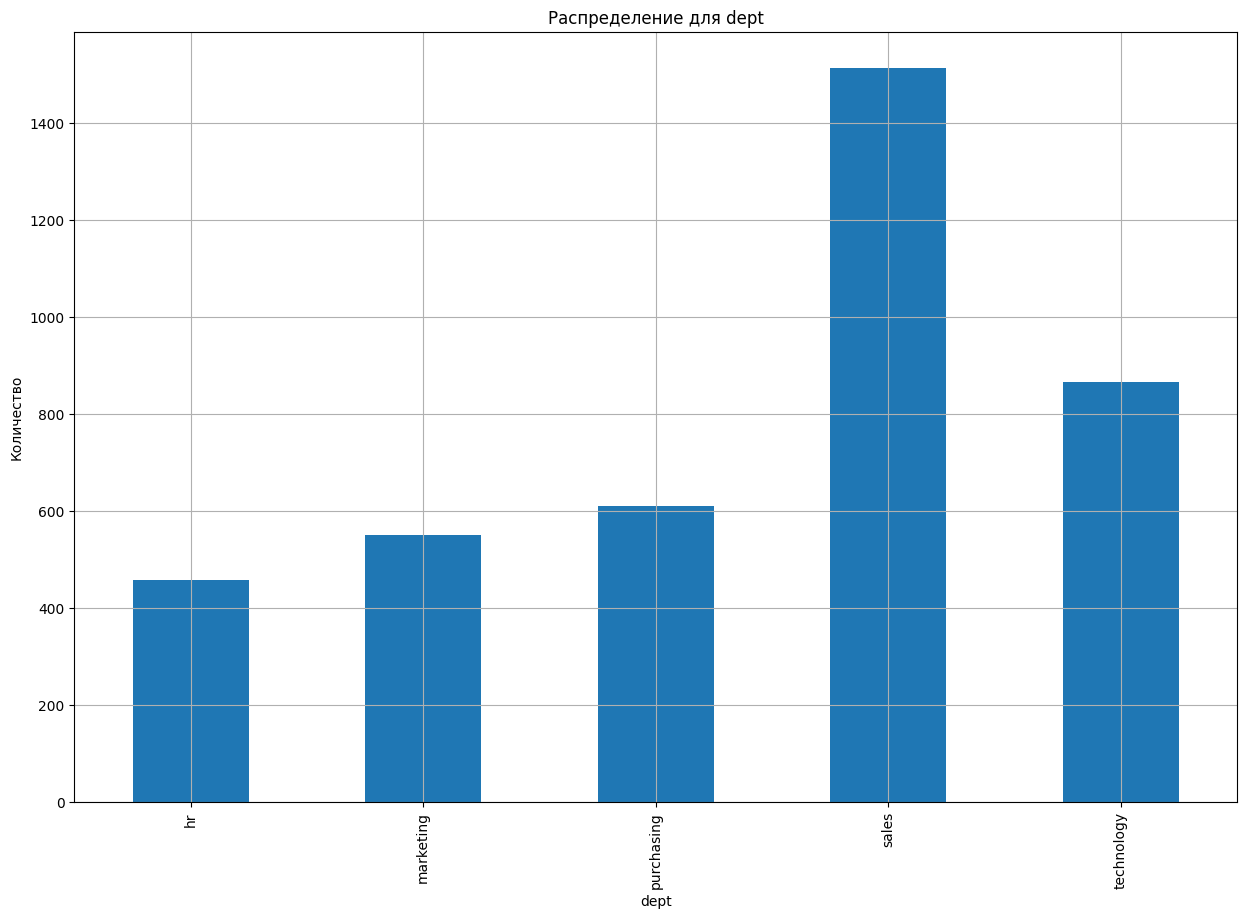

In [14]:
plot_n_describe(train_job_satisfaction_rate.dept, 'bar')

5 отделов, аномалий нет. Можно кодировать OHE 

count       3996
unique         3
top       junior
freq        1894
Name: level, dtype: object

level
junior    47.4
middle    43.6
sinior     9.0
Name: count, dtype: float64

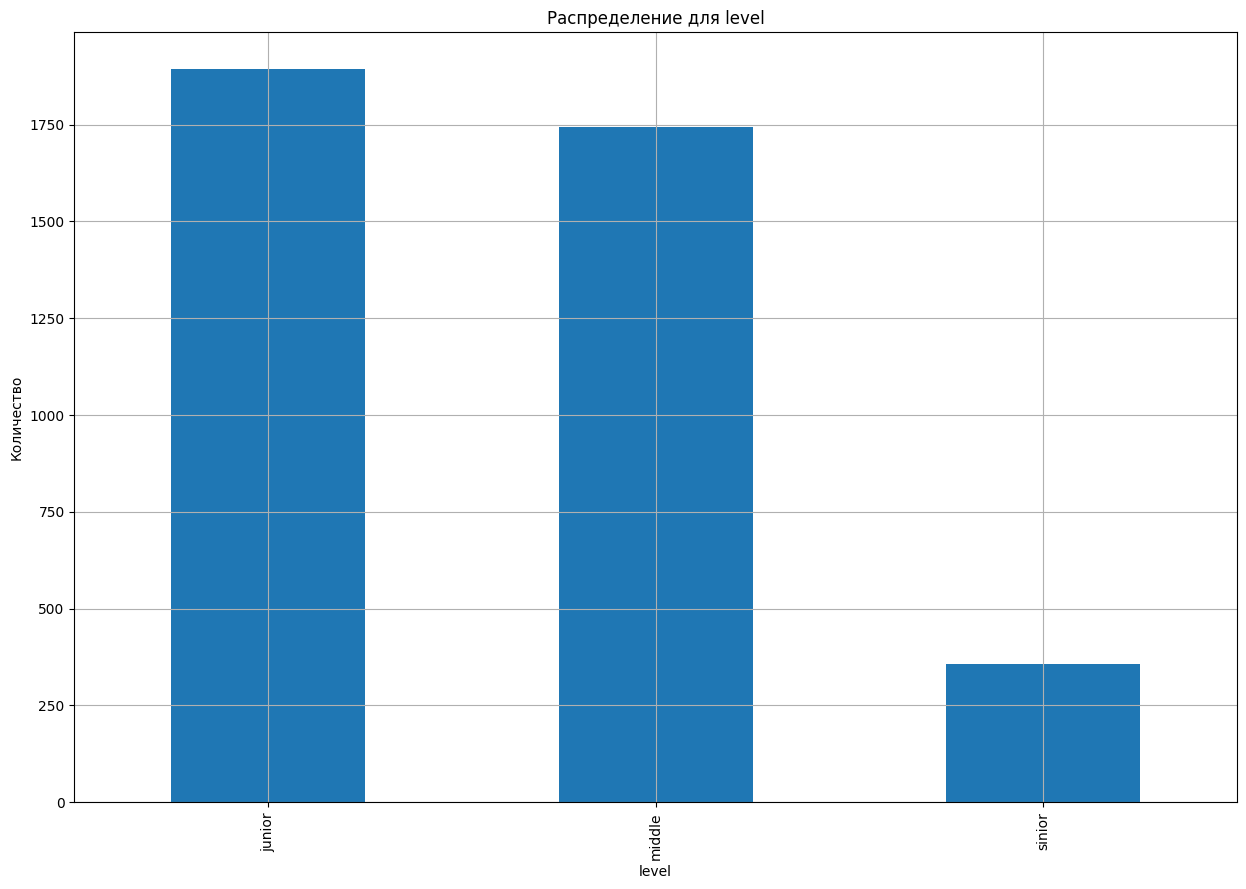

In [15]:
plot_n_describe(train_job_satisfaction_rate.level, 'bar')

3 уровня должности, аномалий нет. Опечатка: sinior -> senior. Можно кодировать Ordinal в порядке junior->middle->sinior

In [16]:
#train_job_satisfaction_rate.level = train_job_satisfaction_rate.level.str.replace('sinior', 'senior')

count       4000
unique         3
top       medium
freq        2066
Name: workload, dtype: object

workload
high      18.4
low       30.0
medium    51.6
Name: count, dtype: float64

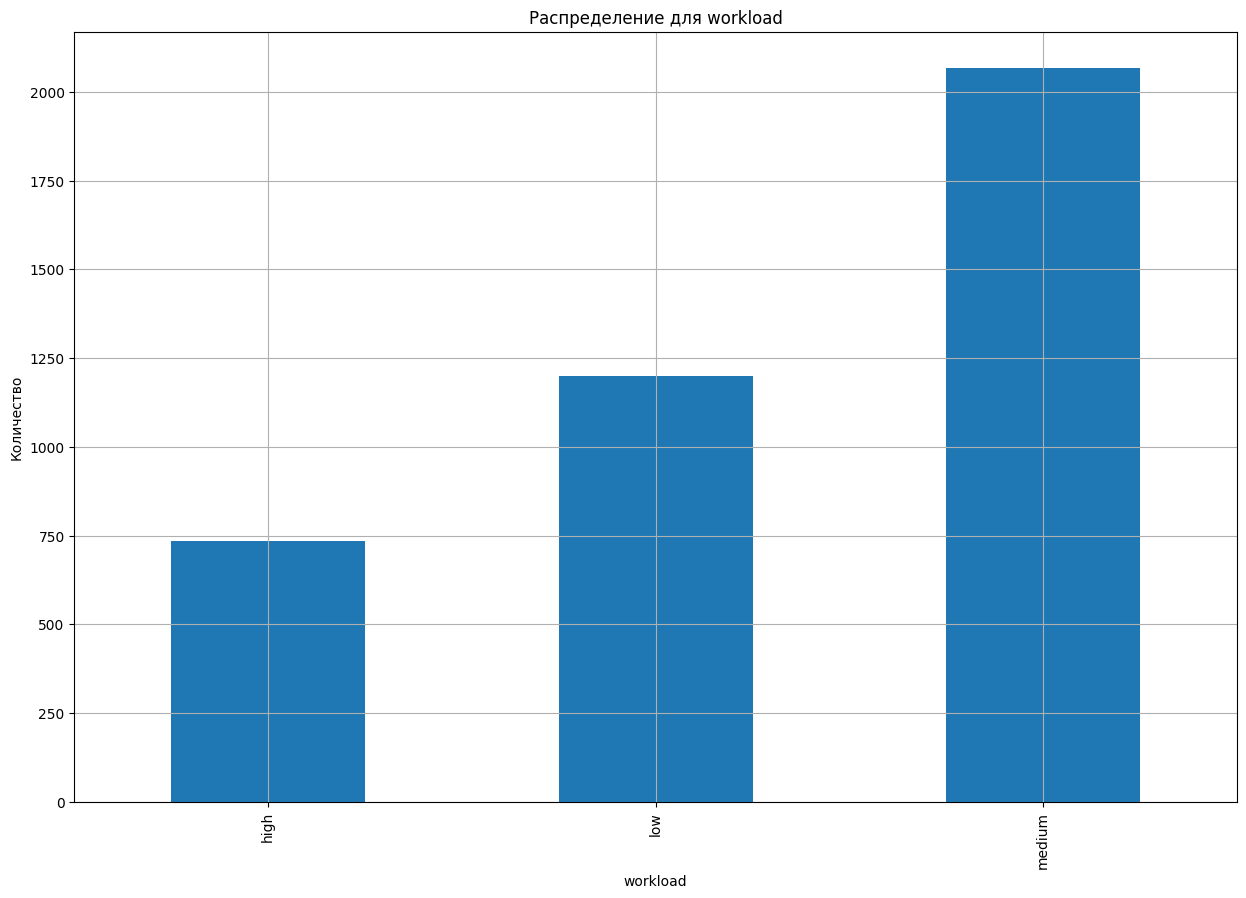

In [17]:
plot_n_describe(train_job_satisfaction_rate.workload, 'bar')

3 уровня нагрузки, аномалий нет. Можно кодировать Ordinal в порядке low->medium->high

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

employment_years
1     24.2
2     19.6
3     12.1
4      9.6
5      9.5
6      7.2
7      7.5
8      4.8
9      3.2
10     2.3
Name: count, dtype: float64

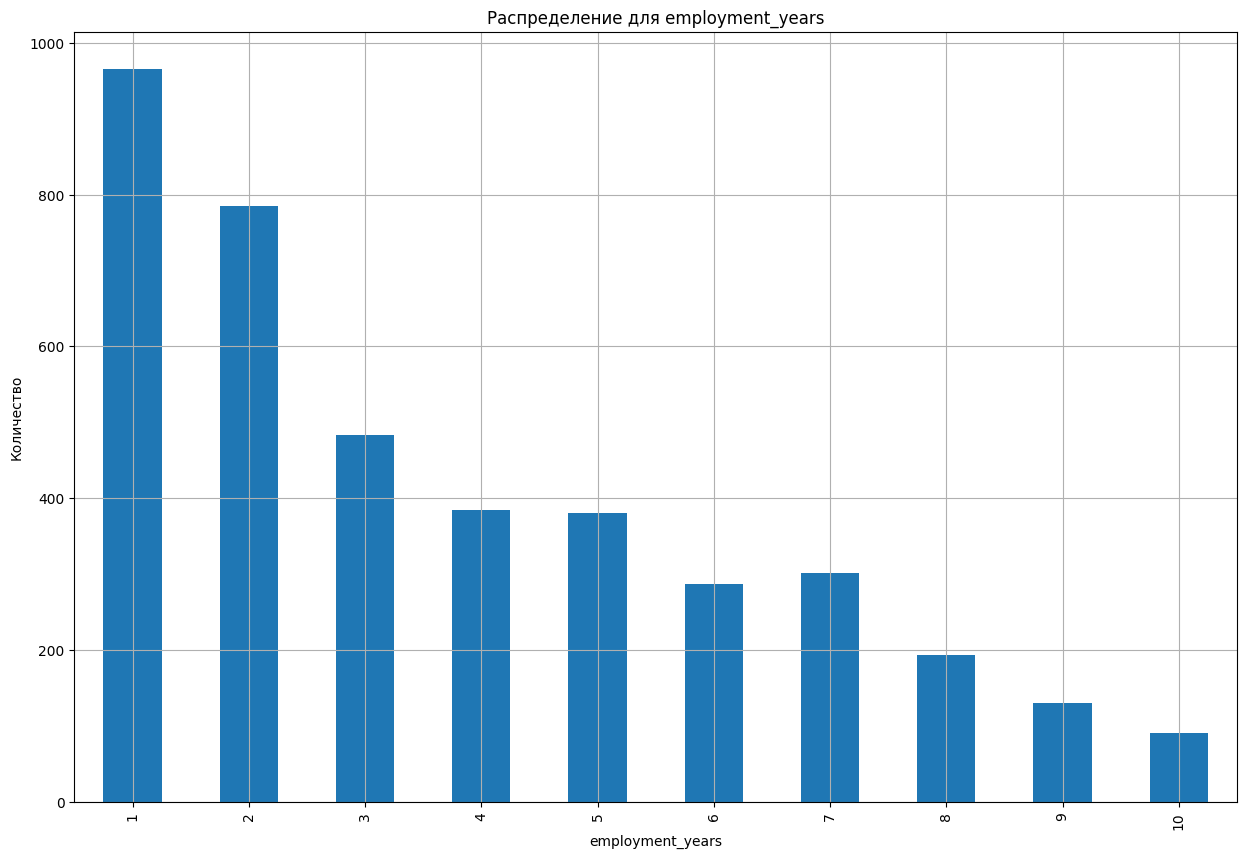

In [18]:
plot_n_describe(train_job_satisfaction_rate.employment_years, 'bar')

Срок работы в компании от 1 до 10 лет, аномалий нет. Лучше отмасштабировать.

count     4000
unique       2
top         no
freq      3880
Name: last_year_promo, dtype: object

last_year_promo
no     97.0
yes     3.0
Name: count, dtype: float64

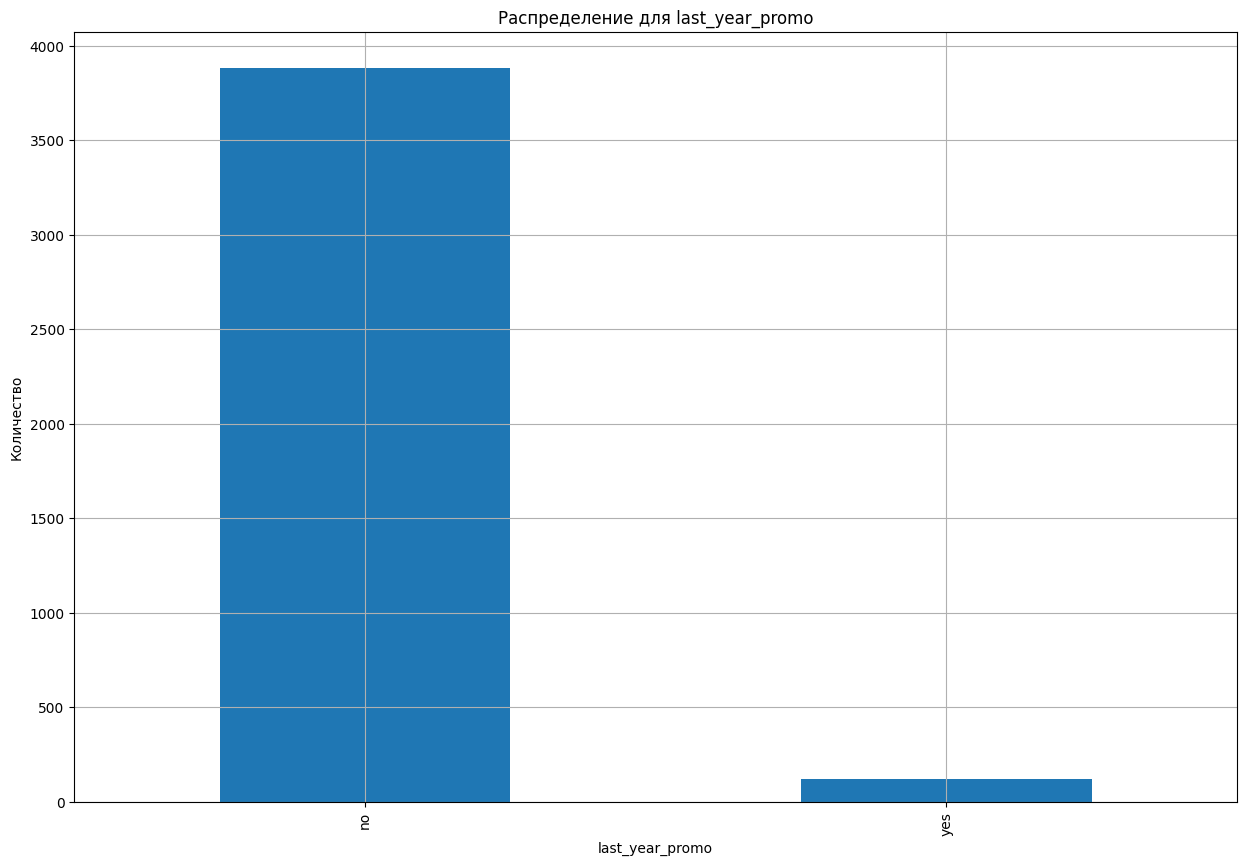

In [19]:
plot_n_describe(train_job_satisfaction_rate.last_year_promo, 'bar')

Повышение за последний год, можно кодировать  Ordinal с yes=1

count     4000
unique       2
top         no
freq      3441
Name: last_year_violations, dtype: object

last_year_violations
no     86.0
yes    14.0
Name: count, dtype: float64

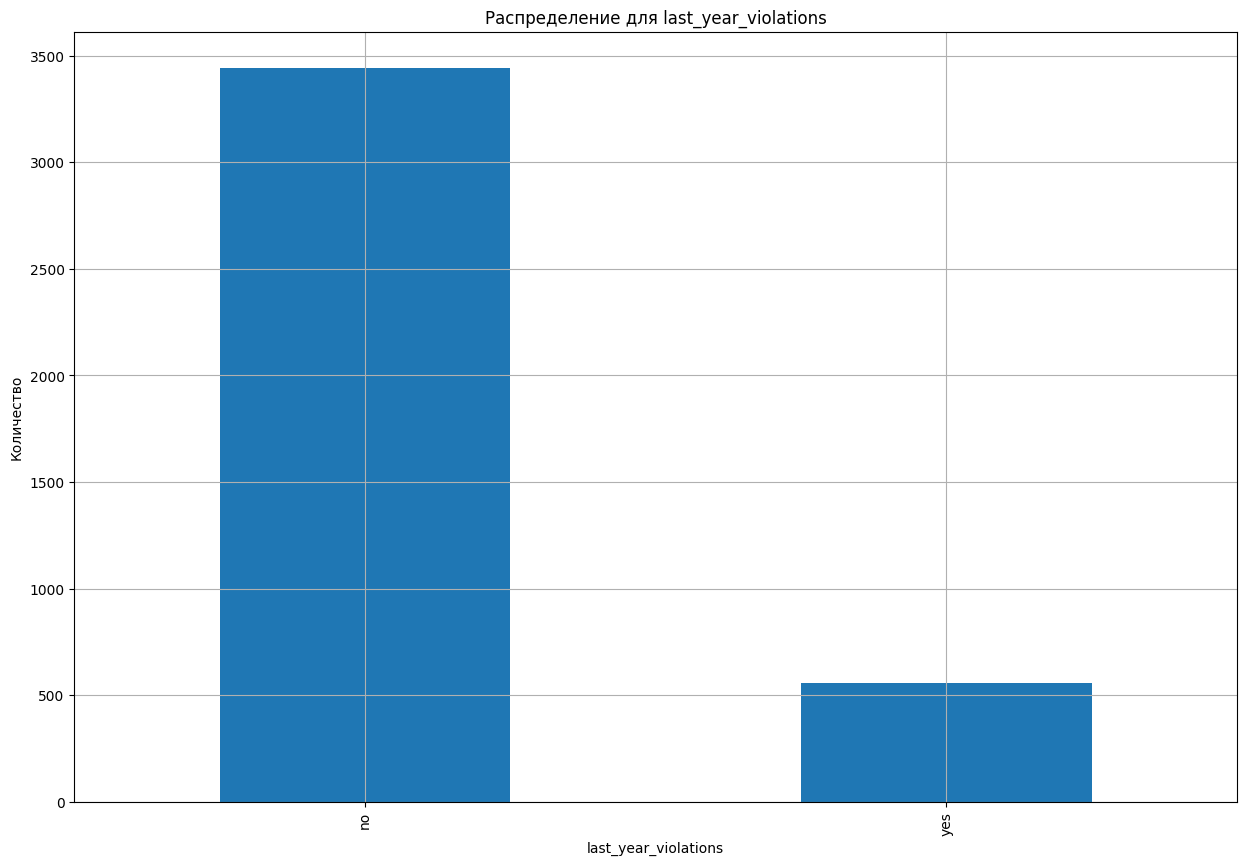

In [20]:
plot_n_describe(train_job_satisfaction_rate.last_year_violations, 'bar')

Наличие "выговоров", можно кодировать  Ordinal с yes=1

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

supervisor_evaluation
1     5.0
2     9.7
3    31.6
4    40.1
5    13.6
Name: count, dtype: float64

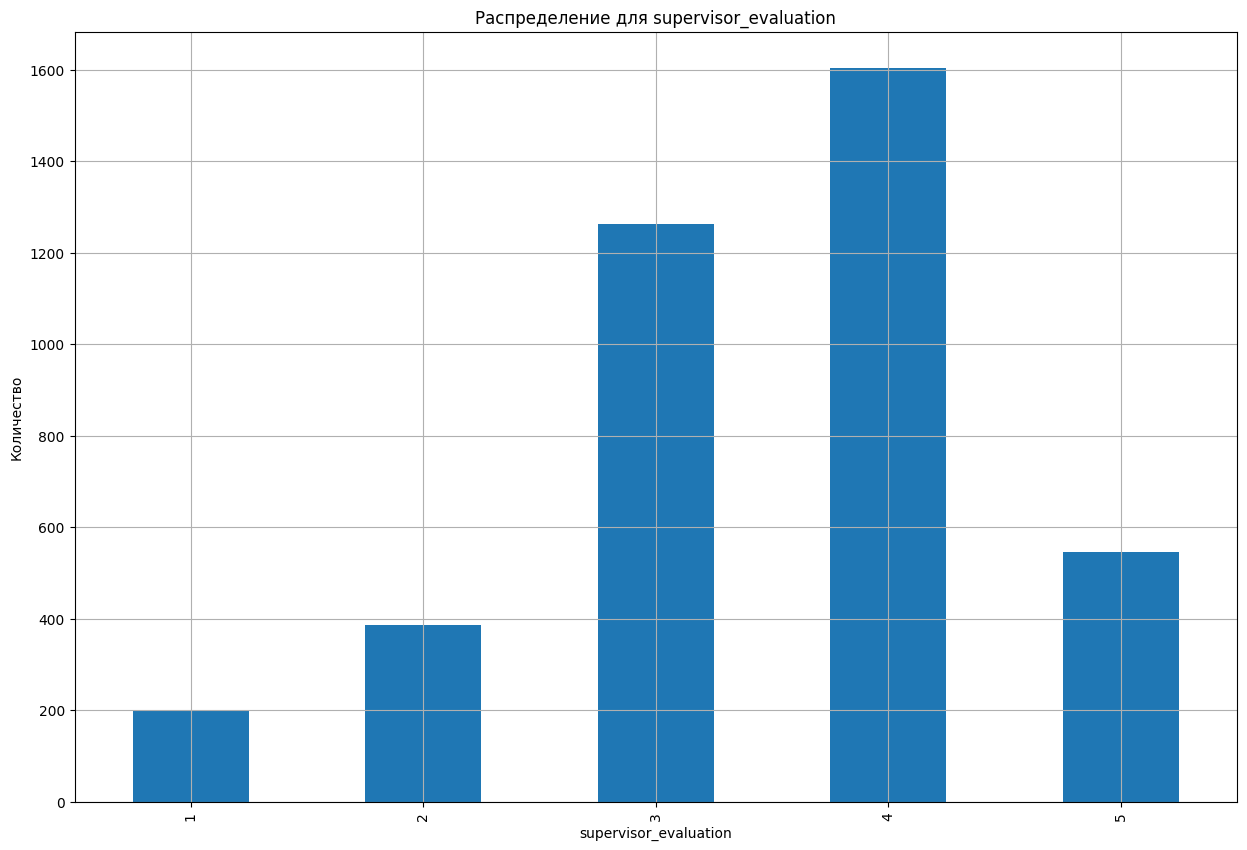

In [21]:
plot_n_describe(train_job_satisfaction_rate.supervisor_evaluation, 'bar')

Оценка от руководителя от 1 до 5, аномалий нет. Лучше отмасштабировать.

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

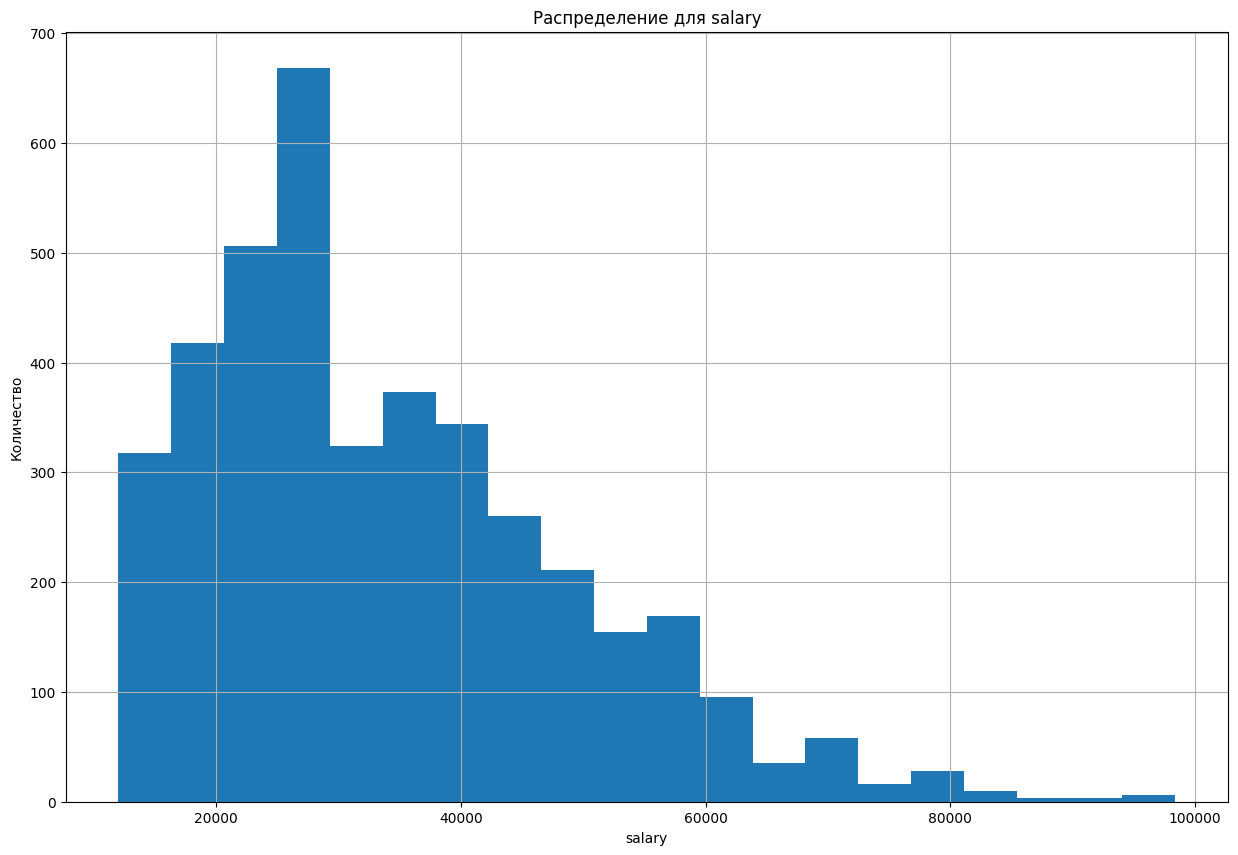

In [22]:
plot_n_describe(train_job_satisfaction_rate.salary, 'hist')

Зарплата, диапазон от 12к до 100к, аномалий нет. Лучше отмасштабировать. Посмотрим "ящик".

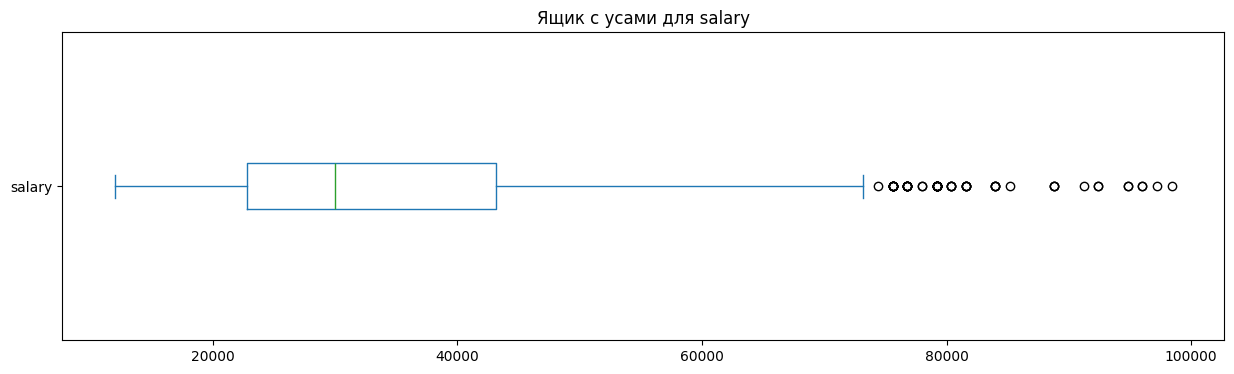

In [23]:
boxplot_xlim(train_job_satisfaction_rate.salary)

Зарплаты выше 75к чуть вылезают за IRQ

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

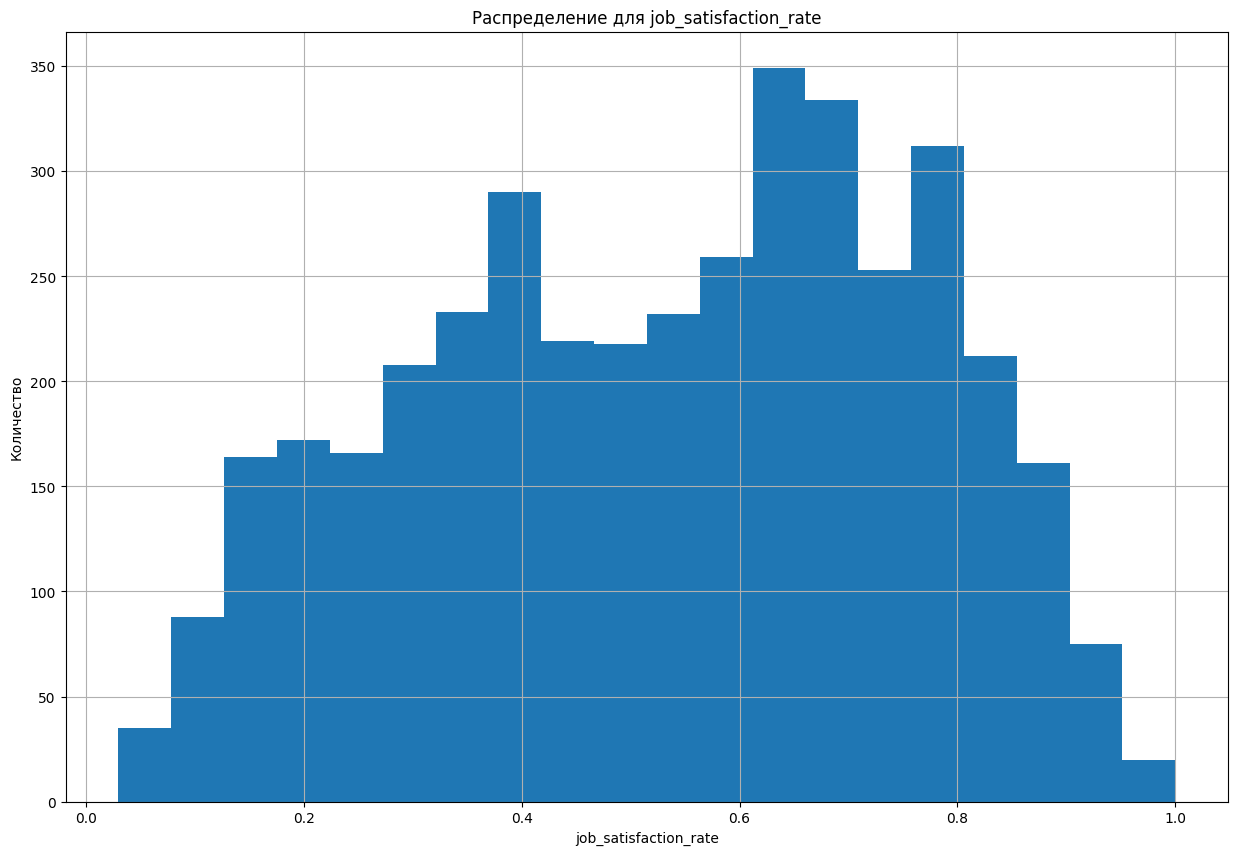

In [24]:
plot_n_describe(train_job_satisfaction_rate.job_satisfaction_rate, 'hist')

Целевой признак, диапазон от 0 до 1

#### test_features

In [25]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


count      1998
unique        6
top       sales
freq        763
Name: dept, dtype: object

dept
               0.1
hr            11.4
marketing     14.0
purchasing    13.7
sales         38.2
technology    22.8
Name: count, dtype: float64

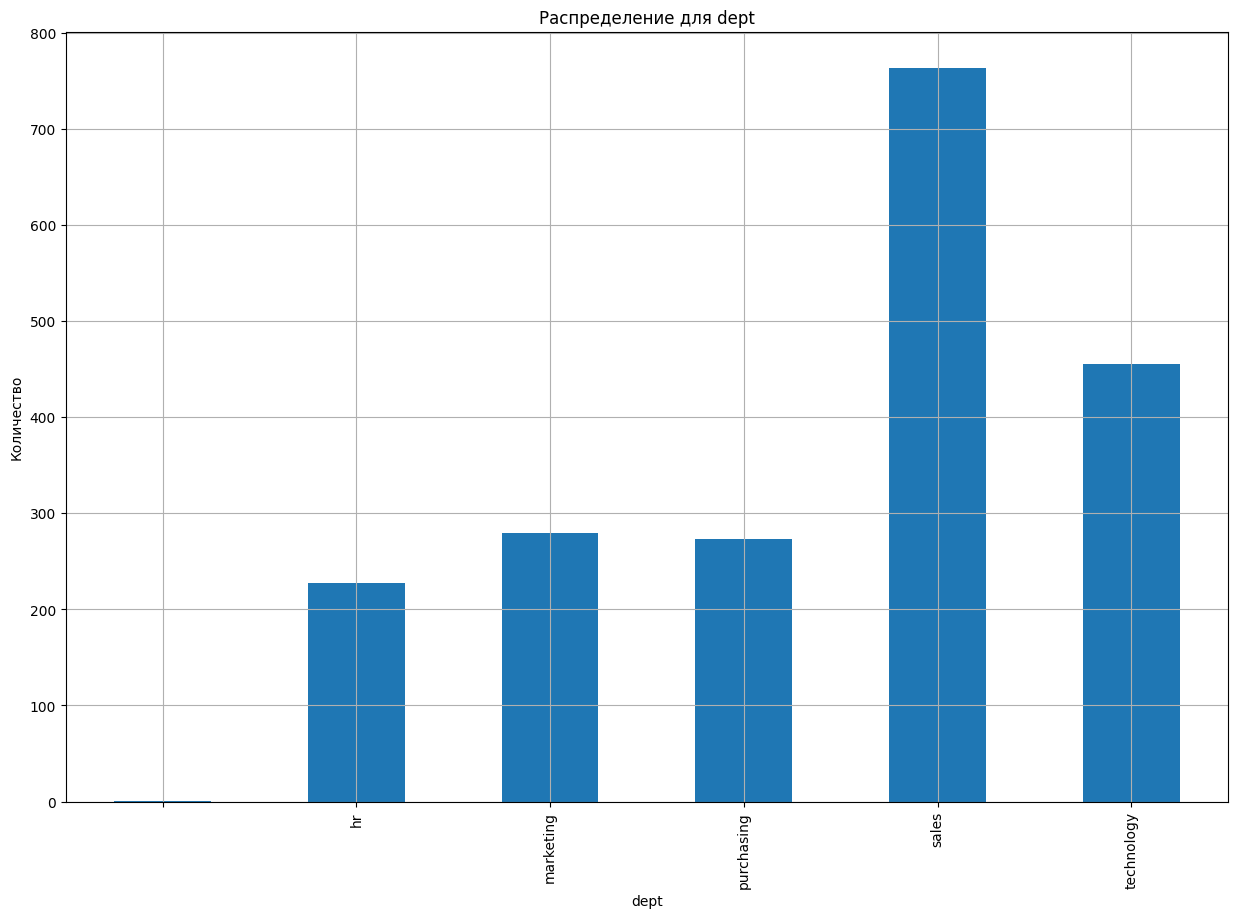

In [26]:
plot_n_describe(test_features.dept, 'bar')

In [27]:
test_features.dept.unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

Те же 5 отделов, есть "настоящие" пропуски и " ", которые по сути тот же пропуск.

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

employment_years
1     26.1
2     18.7
3     11.7
4      9.4
5      9.0
6      6.9
7      8.7
8      4.6
9      3.3
10     1.8
Name: count, dtype: float64

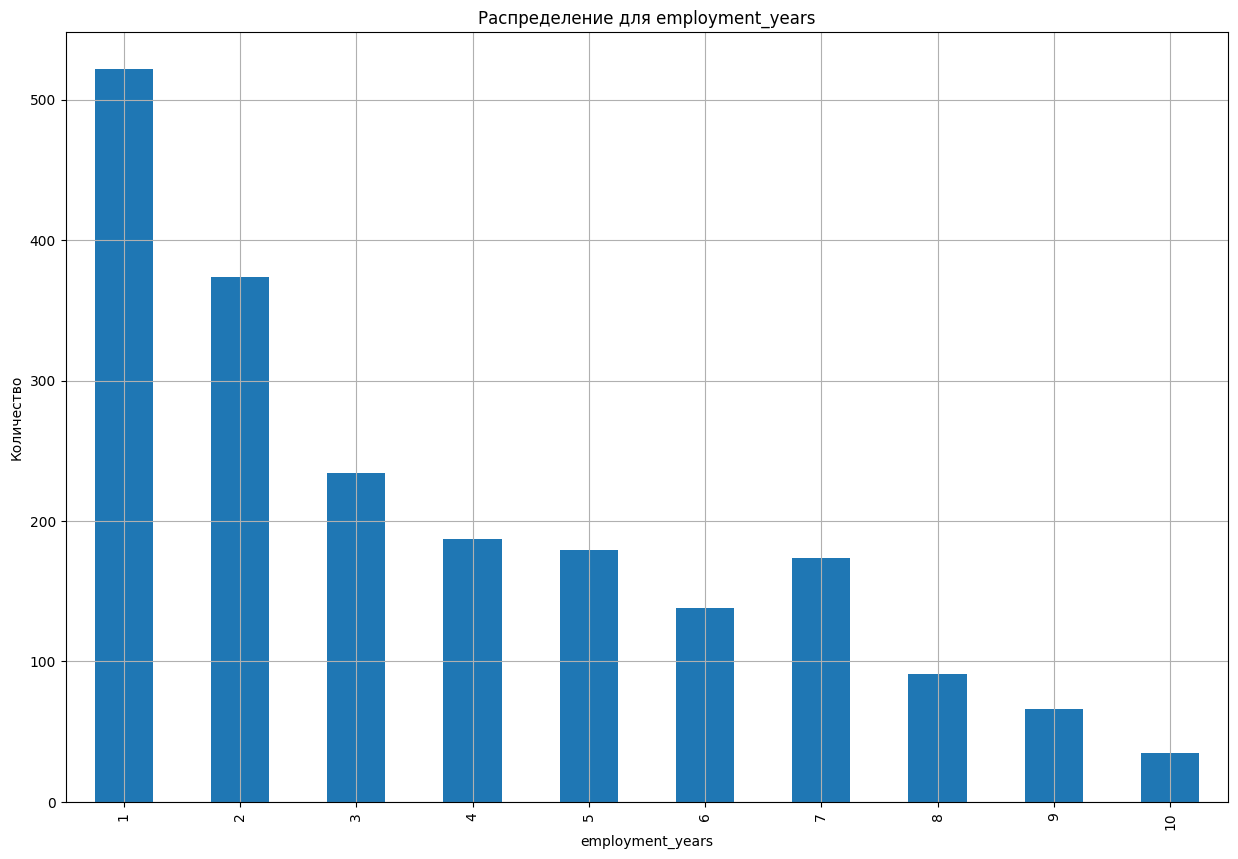

In [28]:
plot_n_describe(test_features.employment_years, 'bar')

Аналогично `train_job_satisfaction_rate`

count     2000
unique       2
top         no
freq      1937
Name: last_year_promo, dtype: object

last_year_promo
no     96.8
yes     3.2
Name: count, dtype: float64

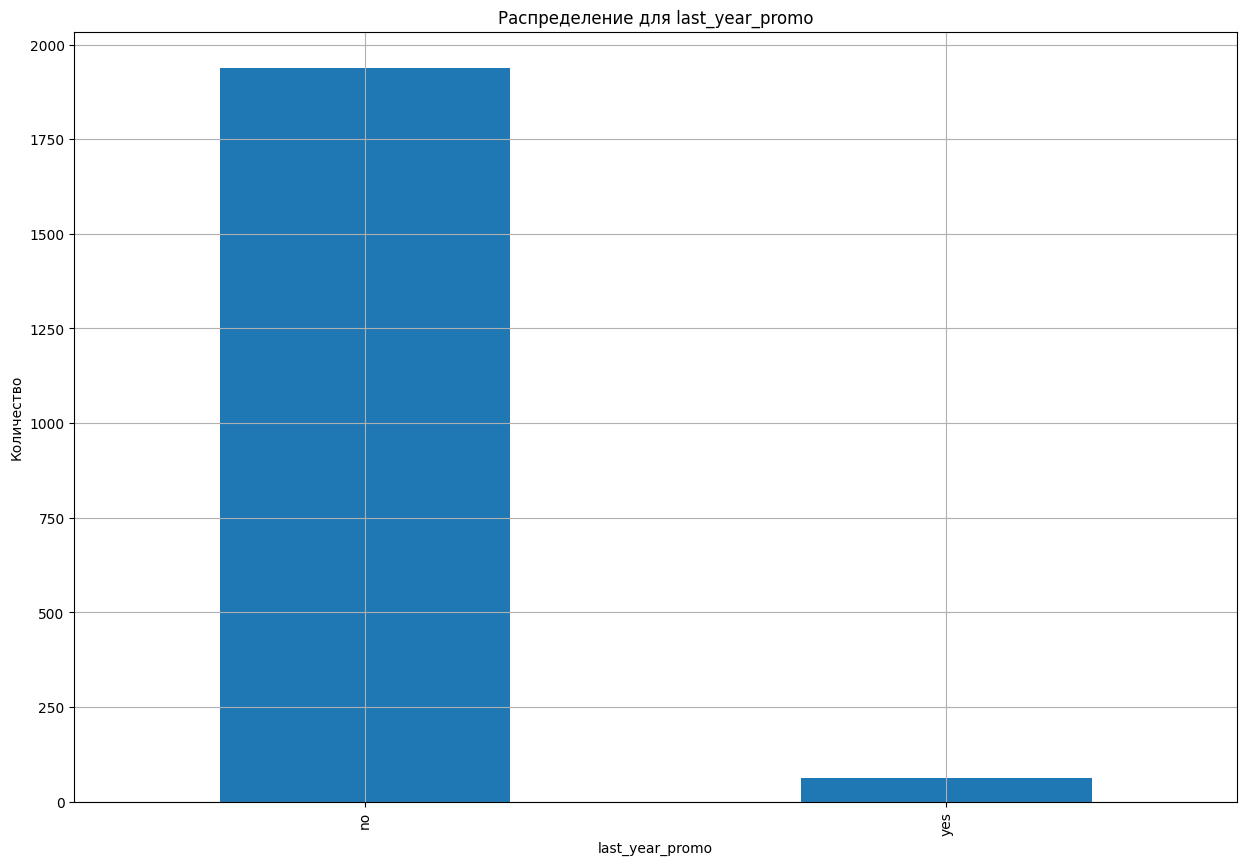

In [29]:
plot_n_describe(test_features.last_year_promo, 'bar')

Аналогично `train_job_satisfaction_rate`

count     2000
unique       2
top         no
freq      1738
Name: last_year_violations, dtype: object

last_year_violations
no     86.9
yes    13.1
Name: count, dtype: float64

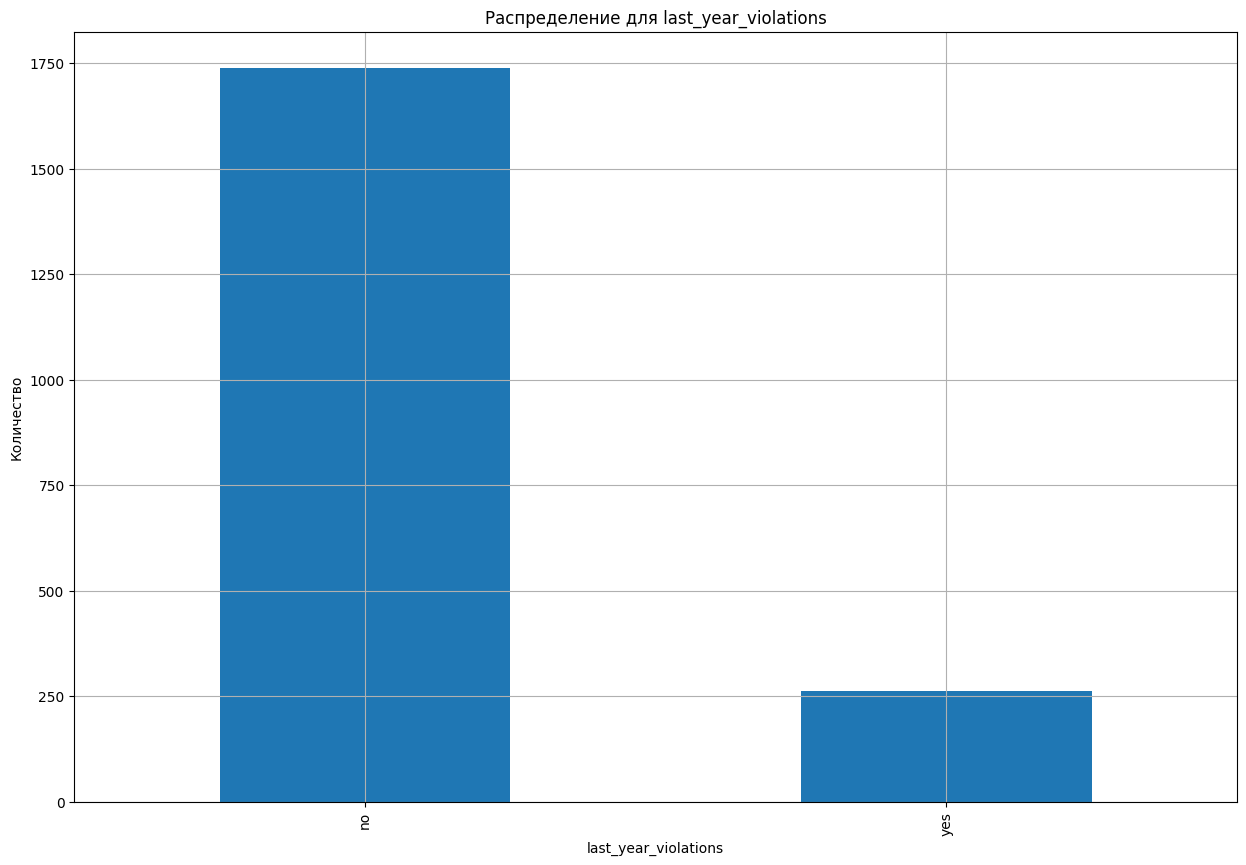

In [30]:
plot_n_describe(test_features.last_year_violations, 'bar')

Аналогично `train_job_satisfaction_rate`

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

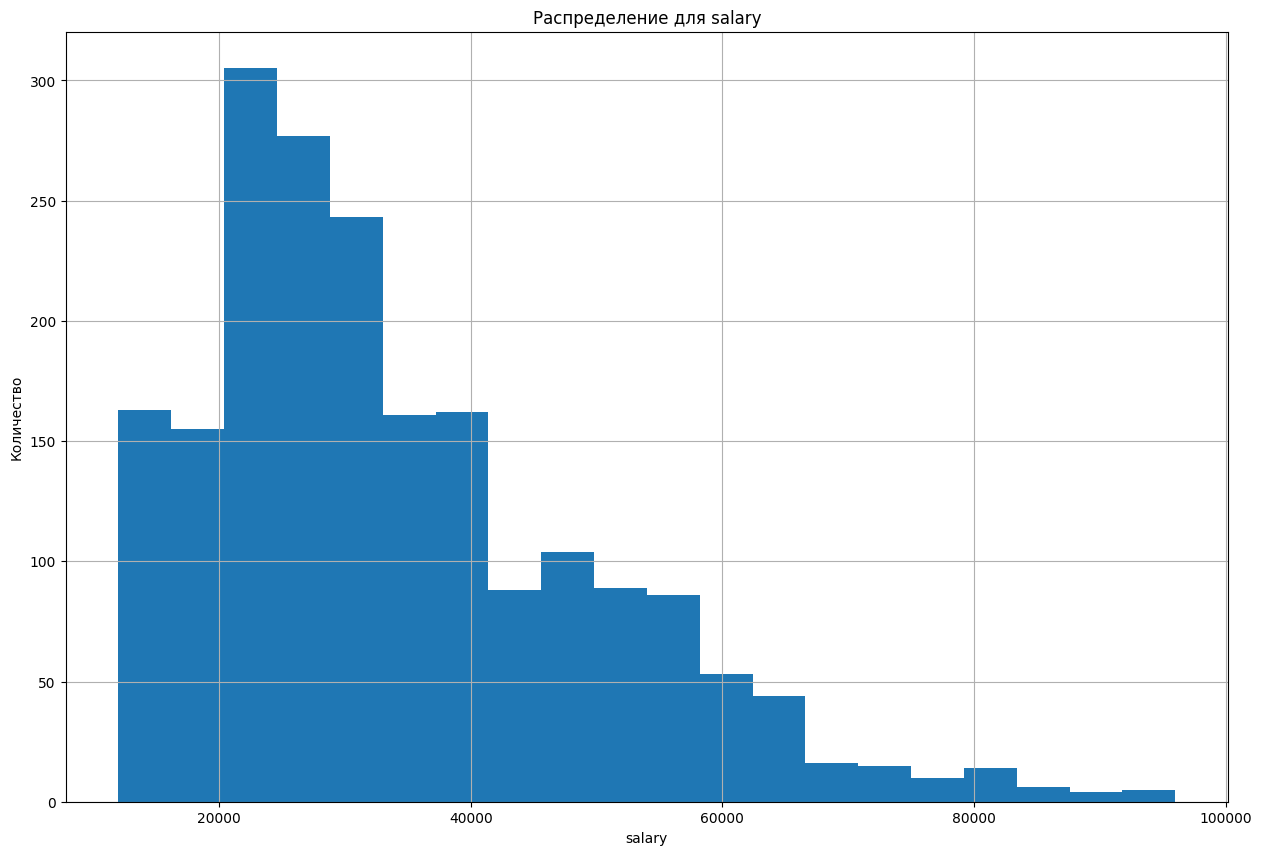

In [31]:
plot_n_describe(test_features.salary, 'hist')

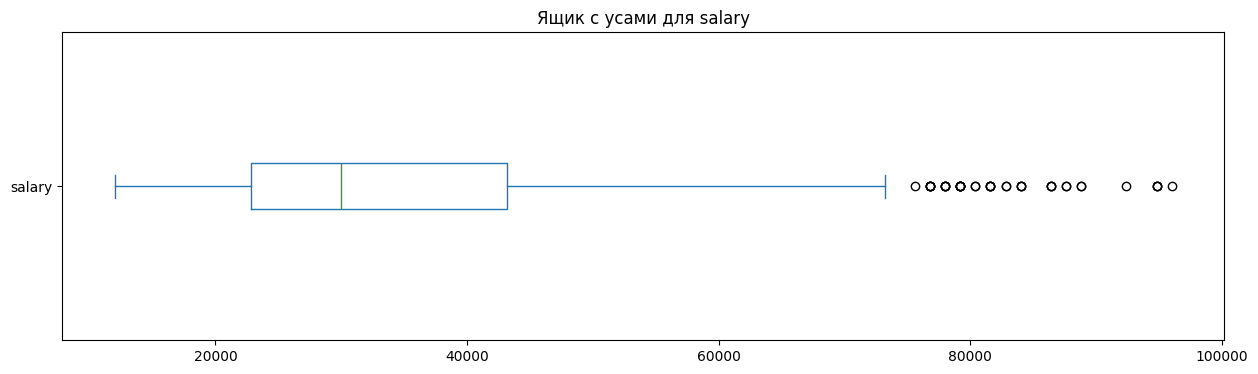

In [32]:
boxplot_xlim(test_features.salary)

Аналогично `train_job_satisfaction_rate`

#### test_target_job_satisfaction_rate

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

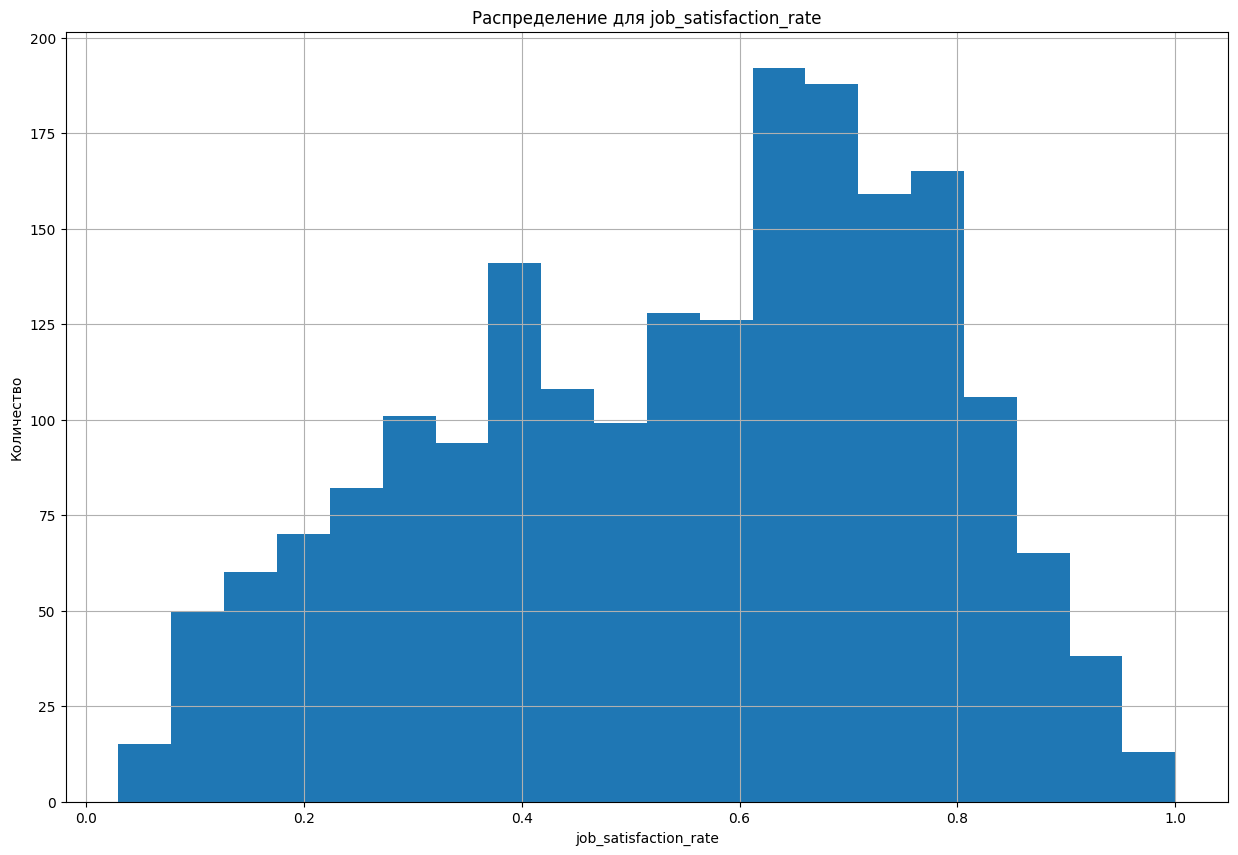

In [33]:
plot_n_describe(test_target_job_satisfaction_rate.job_satisfaction_rate, 'hist')

Аналогично `train_job_satisfaction_rate`

#### Корреляция

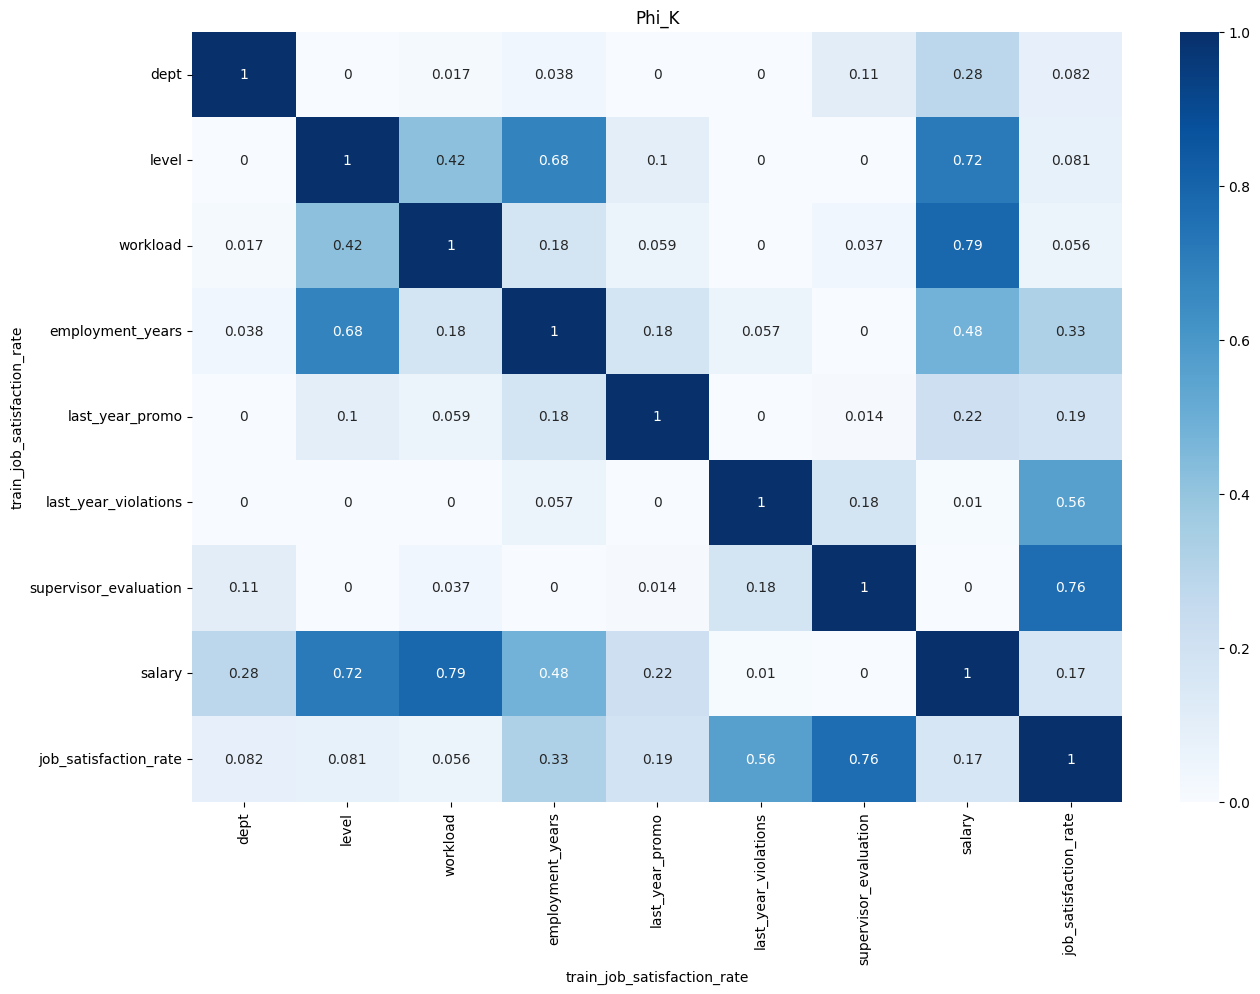

In [34]:
plt.figure(figsize=(15, 10))
sns.heatmap(
    train_job_satisfaction_rate.drop('id', axis=1).phik_matrix(
        interval_cols=[
            'salary',
            'job_satisfaction_rate'
        ]
    ), 
    annot=True, 
    cmap='Blues'
)
plt.title('Phi_K')
plt.show()

тут нужен текст...

#### Итог
В `train_job_satisfaction_rate` всё ок.
В `test_fetures` есть пара необычных пропусков в `dept` и `level` - строка из пробелов. Оставим как есть, чтобы проверить устойчивость пайплайна к такому.
В `test_target_job_satisfaction_rate` тоже всё ок.

### Подготовка данных

#### Пайплайны

In [35]:
# списки колонок по типу кодировщика

ohe_columns = [
    'dept'
]

ord_columns = [
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations'
]

ord_columns_categories = [
    ['junior', 'middle', 'sinior'],
    ['low', 'medium', 'high'],
    ['no', 'yes'],
    ['no', 'yes']
]

num_columns = [
    'employment_years',
    'supervisor_evaluation',
    'salary'
] 

In [36]:
# пайплайны для подготовки

pipe_ohe = Pipeline(
    [
        (
            'pipe_ohe_imputer',
            SimpleImputer(
                strategy='constant',
                fill_value='unknown'
            )
        ),
        
        (
            'pipe_ohe_encoder',
            OneHotEncoder(
                drop='first',
                sparse_output=False,
                handle_unknown='ignore'
            )
        )
    ]
)

pipe_ord = Pipeline(
    [
        (
            'pipe_ord_imputer',
            SimpleImputer(
                strategy='constant',
                fill_value='unknown'
            )
        ),
        
        (
            'pipe_ord_encoder',
            OrdinalEncoder(
                categories=ord_columns_categories,
                handle_unknown='use_encoded_value',
                unknown_value=-1
            )
        )
    ]
)

pipe_num = Pipeline(
    [
        (
            'pipe_num_imputer',
            SimpleImputer(
                strategy='median'
            )
        ),
        
        (
            'pipe_num_encoder',
            StandardScaler()
        )
    ]
)

In [37]:
# собираем подготовку в ColumnTransformer

preprocessor = ColumnTransformer(
    [
        ('ohe', pipe_ohe, ohe_columns),
        
        ('ord', pipe_ord, ord_columns),
        
        ('num', pipe_num, num_columns)
    ]
)

In [38]:
# параметры для GridSearchCV

param_grid = [
    
    {
        'model': [Ridge(random_state=RANDOM_STATE)],
        'model__alpha': np.logspace(-2, 2, 5)  # варьируем силу L2 регуляризации
    },
    
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': range(5, 11) # варьируем максимальную глубину дерева
    } 
]

In [39]:
# итоговый пайплайн, ~без модели по умолчанию~ c DummyRegressor по умолчанию

pipe_final = Pipeline(
    [        
        (
            'preproccessor', 
            preprocessor
        ),
        
        (
            'model', 
            DummyRegressor()
        )
    ]
) 

#### Данные

In [40]:
# train
X_train = train_job_satisfaction_rate.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']

In [41]:
# test
data_test = test_features.merge(
    test_target_job_satisfaction_rate,
    on='id'
)

print(test_features.shape, '+', test_target_job_satisfaction_rate.shape, '=', data_test.shape)

X_test = data_test.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = data_test['job_satisfaction_rate']

(2000, 9) + (2000, 2) = (2000, 10)


### Обучение моделей

#### Метрика SMAPE

In [42]:
def smape(
    y_true,
    y_pred
):
    '''
    расчёт SMAPE
    '''
    res = 200 / y_true.shape[0] * (
        np.abs(y_true - y_pred) 
        / 
        (np.abs(y_true) + np.abs(y_pred))
    ).sum()
    
    return res

In [43]:
smape_score = make_scorer(
    smape, 
    greater_is_better=False # надо для корректного использования SMAPE, метрика при этом станет отрицательной
)

#### Обучение

In [44]:
grid = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_score, 
    n_jobs=-1
)

In [45]:
%%time
grid.fit(X_train, y_train)

CPU times: user 160 ms, sys: 5.56 ms, total: 165 ms
Wall time: 311 ms


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproccessor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         Pipeline(steps=[('pipe_ohe_imputer',
                                                                                          SimpleImputer(fill_value='unknown',
                                                                                                        strategy='constant')),
                                                                                         ('pipe_ohe_encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('pipe_ord_imputer',
                                                                                          SimpleImp...
                                                                         ['employment_years',
                                                                          'supervisor_evaluation',
                                                                          'salary'])])),
                                       ('model', DummyRegressor())]),
             n_jobs=-1,
             param_grid=[{'model': [Ridge(random_state=42)],
                          'model__alpha': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
                         {'model': [DecisionTreeRegressor(random_state=42)],
                          'model__max_depth': range(5, 11)}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [46]:
res = pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__alpha,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.019930,0.002836,0.007213,0.001005,DecisionTreeRegressor(random_state=42),NaN,10.0,{'model': DecisionTreeRegressor(random_state=4...,-16.124258,-15.285210,-15.880665,-16.326947,-15.249115,-15.773239,0.436858,1
9,0.021004,0.001324,0.007668,0.001428,DecisionTreeRegressor(random_state=42),NaN,9.0,{'model': DecisionTreeRegressor(random_state=4...,-16.377280,-15.790142,-16.511344,-16.998516,-15.727268,-16.280910,0.474282,2
8,0.021660,0.001837,0.009583,0.000876,DecisionTreeRegressor(random_state=42),NaN,8.0,{'model': DecisionTreeRegressor(random_state=4...,-17.368614,-16.153145,-16.831275,-17.040078,-16.658081,-16.810239,0.404963,3
7,0.022211,0.000434,0.009260,0.001321,DecisionTreeRegressor(random_state=42),NaN,7.0,{'model': DecisionTreeRegressor(random_state=4...,-17.741194,-16.873632,-17.603632,-17.867317,-17.116288,-17.440413,0.380961,4
6,0.021717,0.000629,0.009813,0.000183,DecisionTreeRegressor(random_state=42),NaN,6.0,{'model': DecisionTreeRegressor(random_state=4...,-19.694158,-18.205071,-18.911483,-18.997860,-17.761778,-18.714070,0.670227,5
5,0.021150,0.001128,0.010040,0.000362,DecisionTreeRegressor(random_state=42),NaN,5.0,{'model': DecisionTreeRegressor(random_state=4...,-19.646342,-19.603801,-19.973804,-19.917685,-19.210986,-19.670524,0.271764,6
2,0.018689,0.001335,0.007463,0.001161,Ridge(random_state=42),1.00,NaN,"{'model': Ridge(random_state=42), 'model__alph...",-25.085720,-25.834395,-25.831687,-25.239500,-23.198974,-25.038055,0.968409,7
3,0.016250,0.002373,0.006618,0.001153,Ridge(random_state=42),10.00,NaN,"{'model': Ridge(random_state=42), 'model__alph...",-24.927084,-25.869949,-25.917604,-25.266016,-23.224977,-25.041126,0.981544,8
1,0.021265,0.000716,0.009027,0.001389,Ridge(random_state=42),0.10,NaN,"{'model': Ridge(random_state=42), 'model__alph...",-25.108499,-25.835973,-25.825032,-25.240895,-23.195896,-25.041259,0.969083,9
0,0.022638,0.001189,0.010281,0.000313,Ridge(random_state=42),0.01,NaN,"{'model': Ridge(random_state=42), 'model__alph...",-25.110858,-25.836217,-25.824365,-25.241252,-23.195544,-25.041647,0.969197,10


In [47]:
for model_name in res.param_model.unique():
    display(  
        res[res.param_model == model_name].sort_values(by='rank_test_score').head(1)
    )

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__alpha,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.01993,0.002836,0.007213,0.001005,DecisionTreeRegressor(random_state=42),NaN,10.0,{'model': DecisionTreeRegressor(random_state=4...,-16.124258,-15.28521,-15.880665,-16.326947,-15.249115,-15.773239,0.436858,1


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__alpha,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.018689,0.001335,0.007463,0.001161,Ridge(random_state=42),1.0,NaN,"{'model': Ridge(random_state=42), 'model__alph...",-25.08572,-25.834395,-25.831687,-25.2395,-23.198974,-25.038055,0.968409,7


#### Тестирование

In [48]:
smape_score = grid.score(X_test, y_test)
print(f'SMAPE для тестовой: {- smape_score:.1f}')

SMAPE для тестовой: 14.9


/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [49]:
pipe_final.fit(X_train, y_train)
y_test_pred_dummy = pipe_final.predict(X_test)
smape_score_dummy = smape(y_test, y_test_pred_dummy)
print(f'SMAPE для тестовой на DummyRegressor: {smape_score_dummy:.1f}')

SMAPE для тестовой на DummyRegressor: 38.2


/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### Итог
Дерево показало себя сильно лучше простой линейной модели с регуляризацией.
Для дерева варьирование максимальной глубины позволило улучшить SMAPE с 19.7 до 15.8.
Для линейной модели SMAPE остаётся около 25 вне зависимости от силы регуляризации.

При проверке модели на тестовых данных метрика получилась 14.9.
То есть качество модели примерно идентично на обучающей и тестовой выборке.
Это позволяет сказать, что переобучения нет.

### Промежуточные выводы

- При загрузке данных проблем не было, предобработка и исследовательский анализ также критических проблем не выявили.

- Обработка пропусков и кодирование были полностью сделаны в пайплайне, устойчивость к новым значениям категориальных признаков проверена

- С использованием GridSearchCV была найдена лучшая модель и её гиперпараметры. В качестве метрики была использована SMAPE.

- При проверке на тестовых данных модель показала качество, практически идентичное результатам на обучающей.

## Задача 2

### Загрузка данных

In [50]:
train_quit = pd_read_csv_wrap('train_quit')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

train_quit,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [51]:
test_target_quit = pd_read_csv_wrap('test_target_quit')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

test_target_quit,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


#### Итог
Всё загрузилось нормально, типы в порядке.

### Предобработка данных

In [52]:
missing_duplicated_check(train_quit)

=== train_quit ===
Пропуски


train_quit
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Полные дубликаты


0

Дубликаты по id


0

In [53]:
missing_duplicated_check(test_target_quit)

=== test_target_quit ===
Пропуски


test_target_quit
id      0
quit    0
dtype: int64

Полные дубликаты


0

Дубликаты по id


0

#### Итог
Пропусков и дубликатов нет

### Исследовательский анализ данных

#### train_quit

In [54]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


count      4000
unique        5
top       sales
freq       1438
Name: dept, dtype: object

dept
hr            11.6
marketing     14.6
purchasing    14.7
sales         36.0
technology    23.2
Name: count, dtype: float64

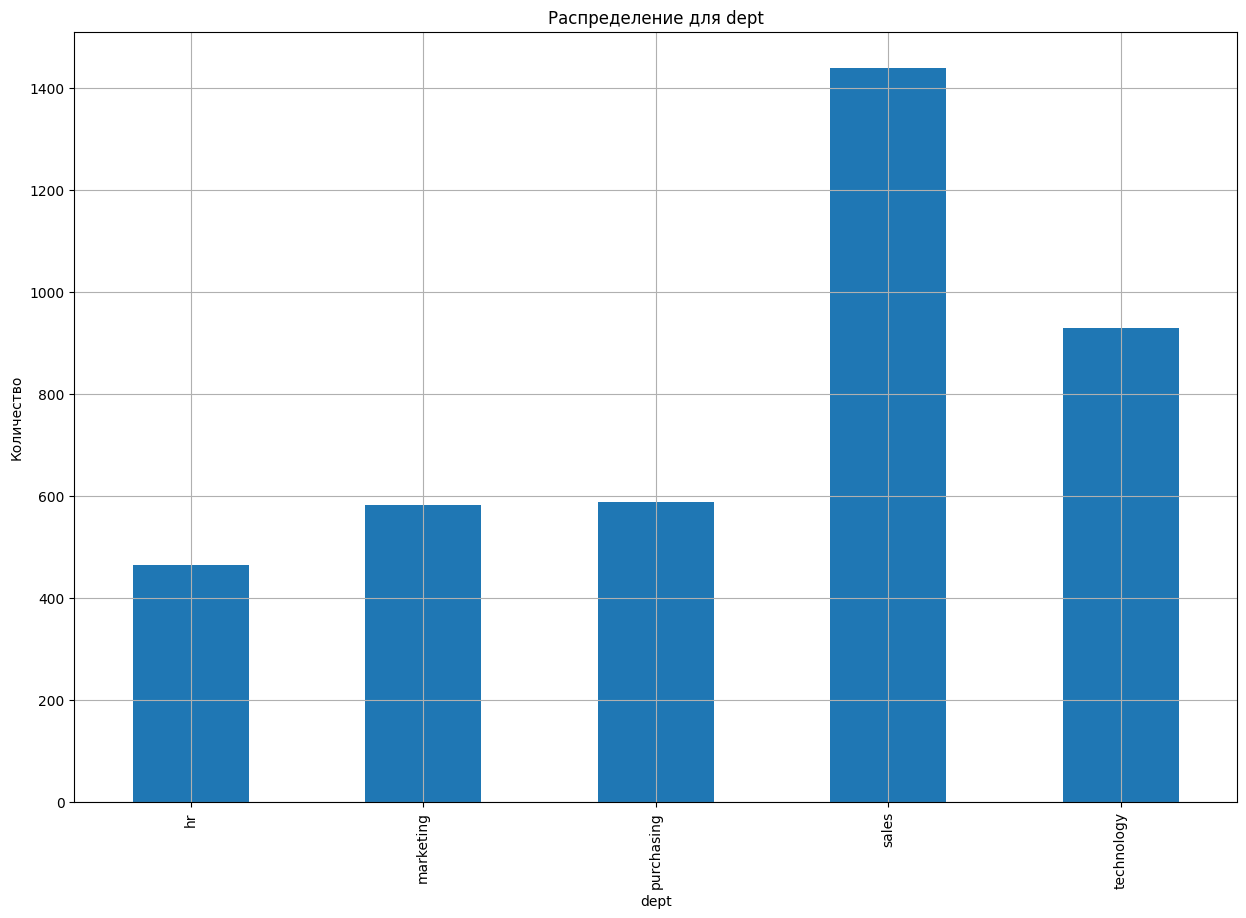

In [55]:
plot_n_describe(train_quit.dept, 'bar')

Уже знакомые 5 отделов, всё ок

count       4000
unique         3
top       junior
freq        1949
Name: level, dtype: object

level
junior    48.7
middle    42.4
sinior     8.9
Name: count, dtype: float64

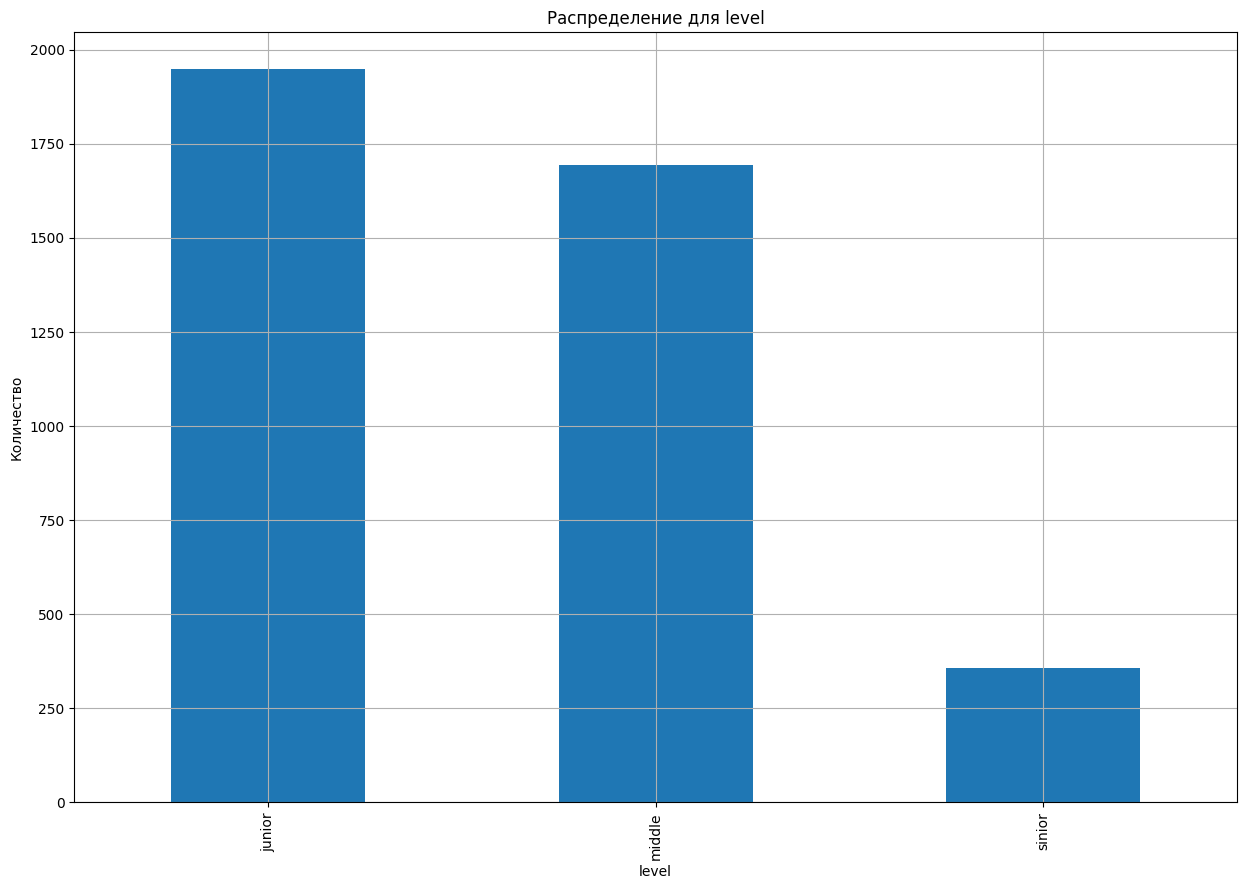

In [56]:
plot_n_describe(train_quit.level, 'bar')

Те же 3 уровня, всё ок

count       4000
unique         3
top       medium
freq        2118
Name: workload, dtype: object

workload
high      16.8
low       30.2
medium    53.0
Name: count, dtype: float64

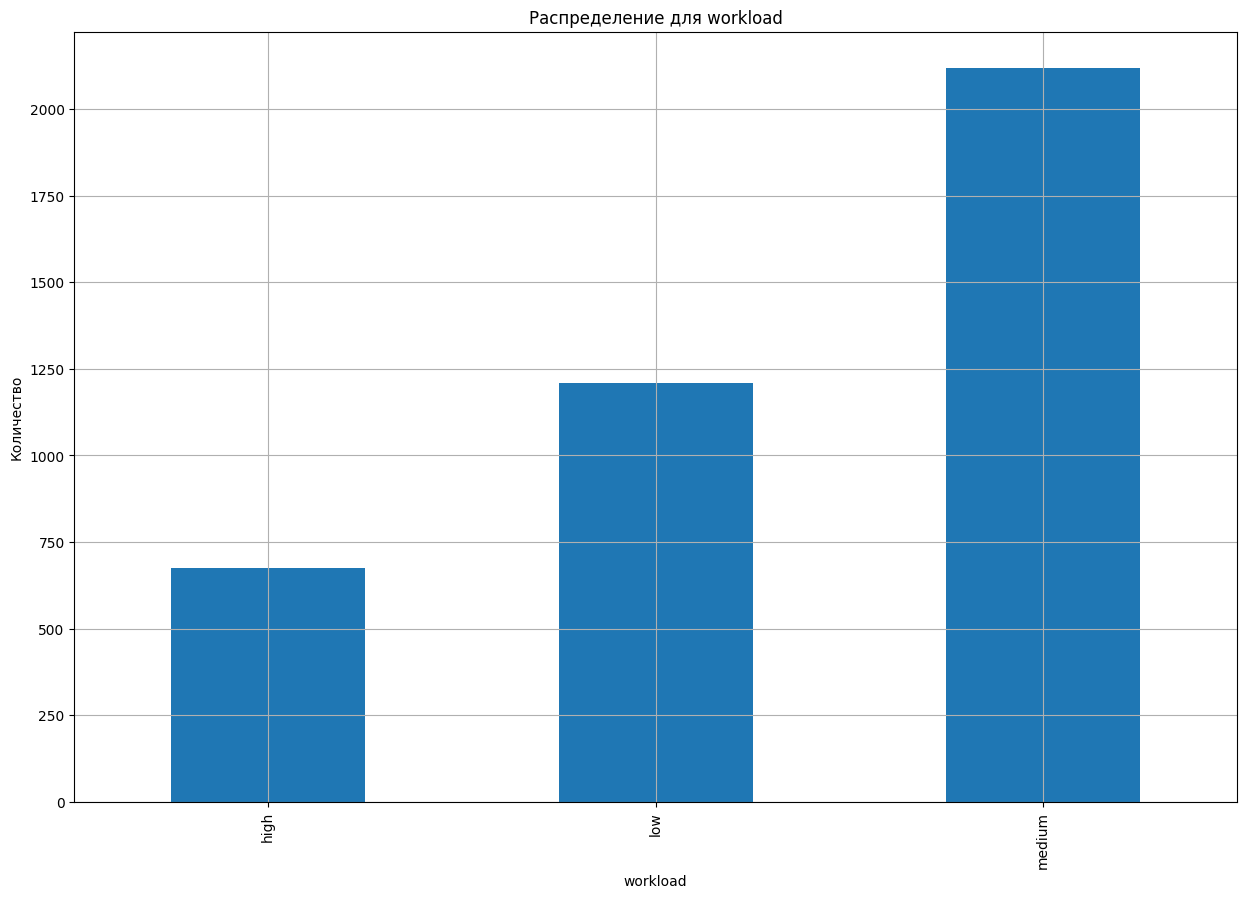

In [57]:
plot_n_describe(train_quit.workload, 'bar')

Всё ок, те же 3 уровня нагрузки

count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

employment_years
1     24.6
2     19.4
3     12.0
4      9.8
5      9.0
6      7.4
7      7.7
8      4.4
9      3.4
10     2.2
Name: count, dtype: float64

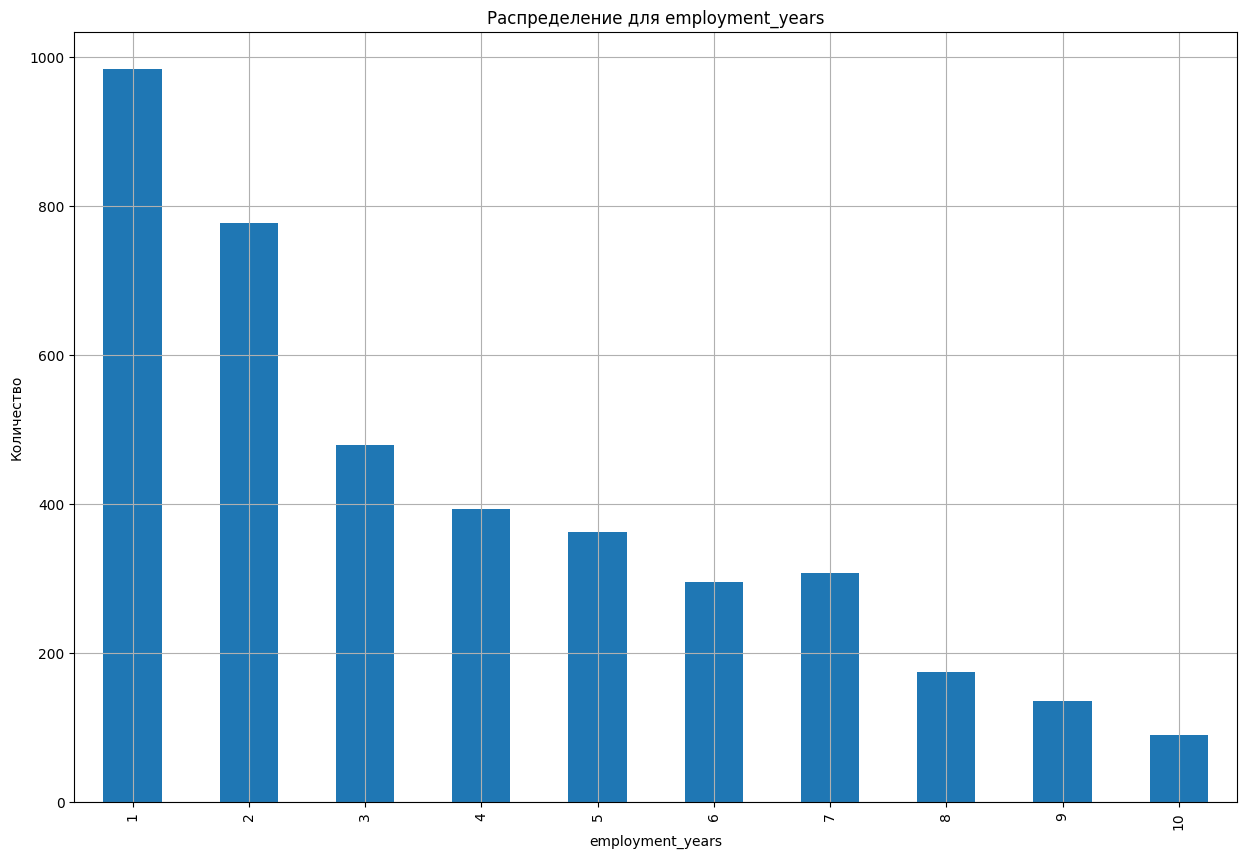

In [58]:
plot_n_describe(train_quit.employment_years, 'bar')

Опять от 1 до 10 лет стаж

count     4000
unique       2
top         no
freq      3887
Name: last_year_promo, dtype: object

last_year_promo
no     97.2
yes     2.8
Name: count, dtype: float64

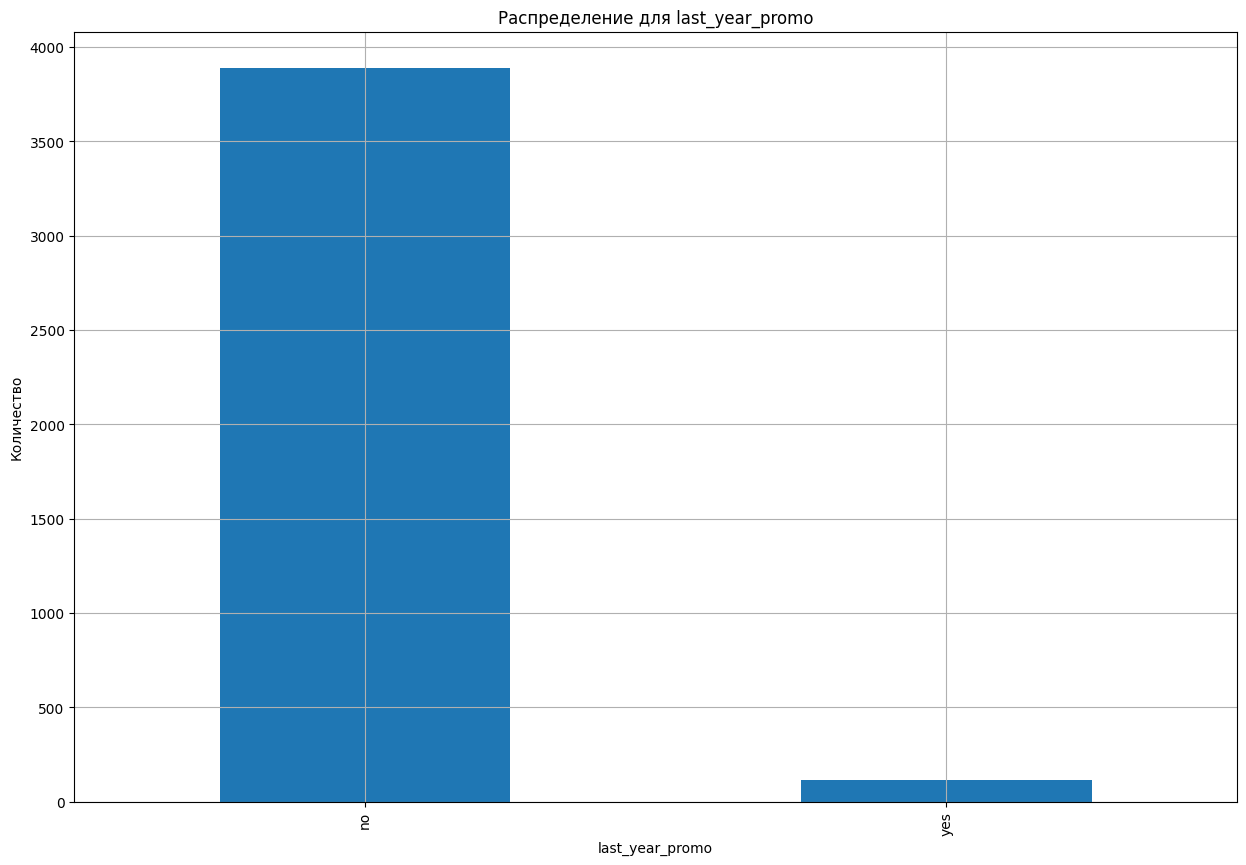

In [59]:
plot_n_describe(train_quit.last_year_promo, 'bar')

Аномалий нет

count     4000
unique       2
top         no
freq      3455
Name: last_year_violations, dtype: object

last_year_violations
no     86.4
yes    13.6
Name: count, dtype: float64

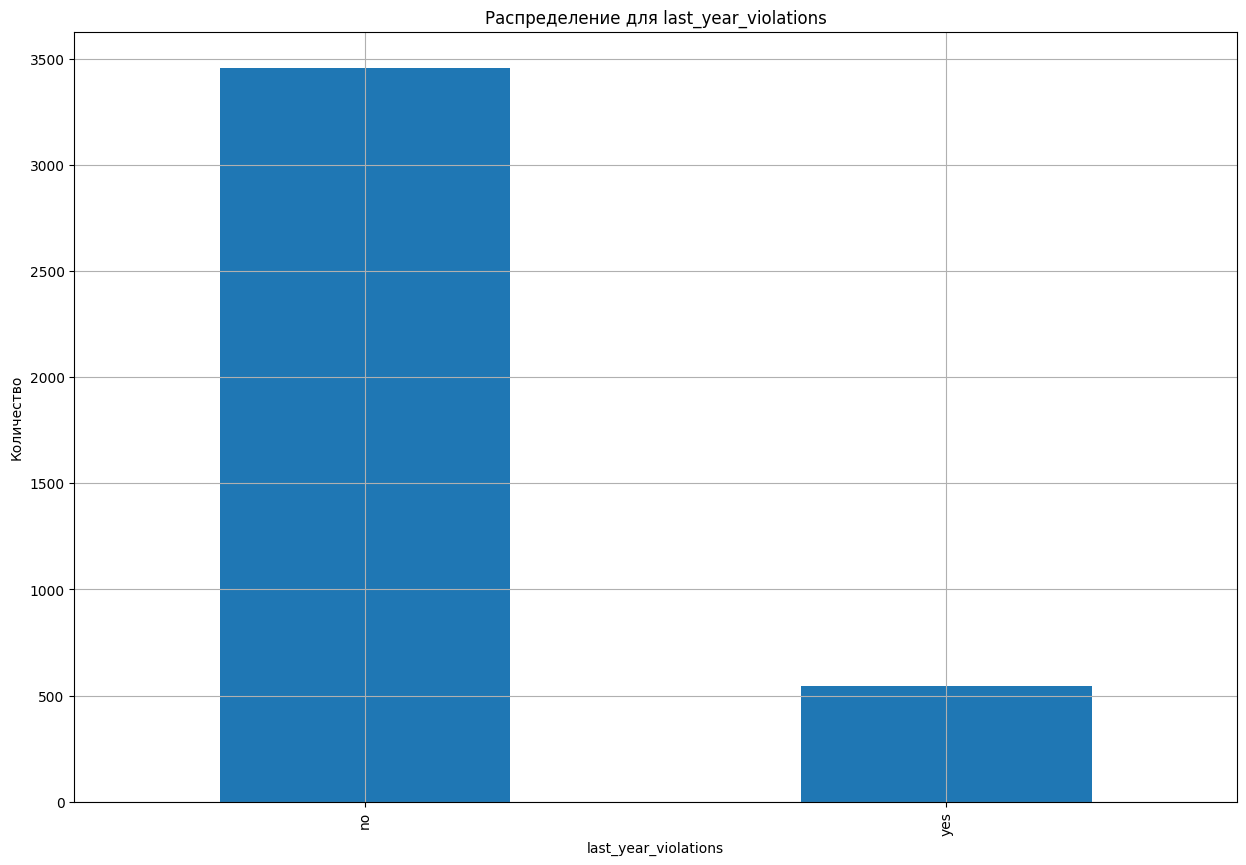

In [60]:
plot_n_describe(train_quit.last_year_violations, 'bar')

Аномалий нет

count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

supervisor_evaluation
1     5.0
2     9.8
3    30.8
4    41.4
5    13.0
Name: count, dtype: float64

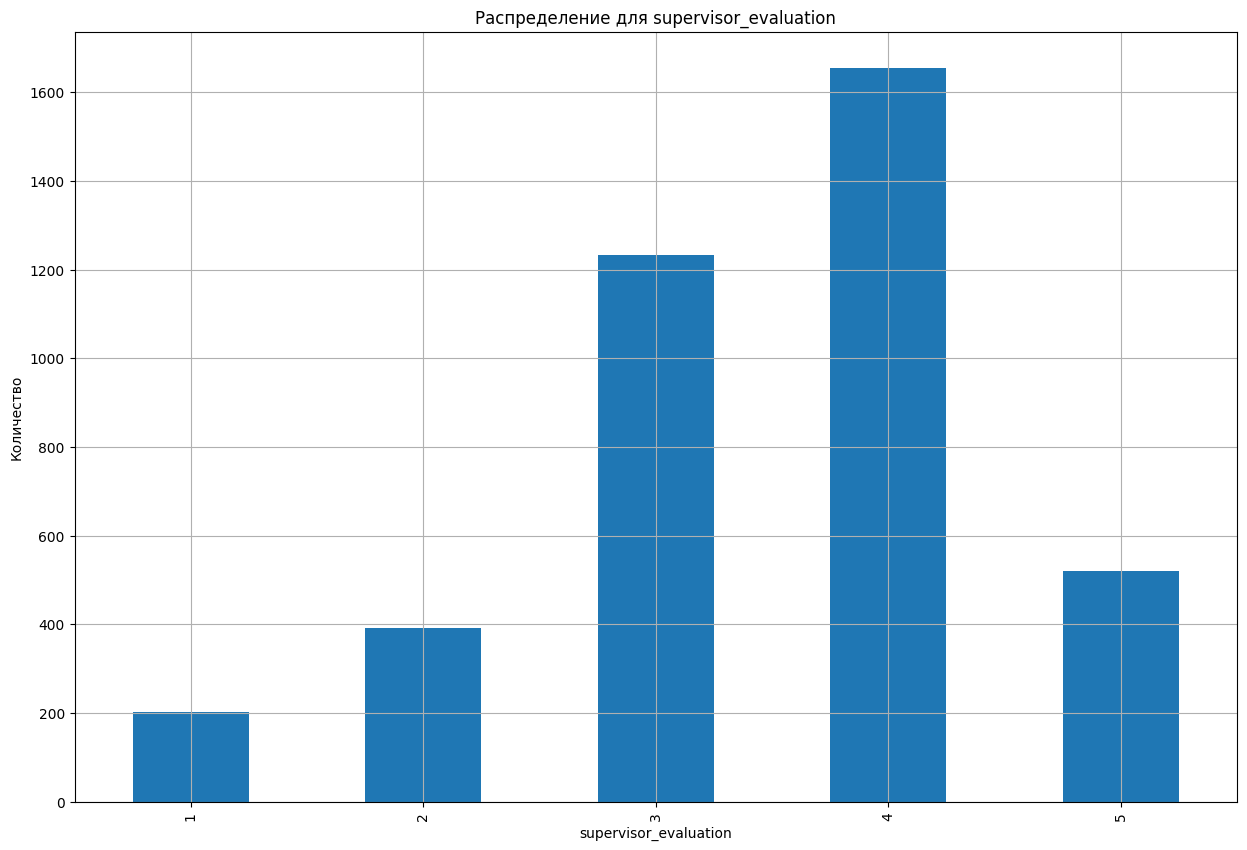

In [61]:
plot_n_describe(train_quit.supervisor_evaluation, 'bar')

Аномалий нет

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

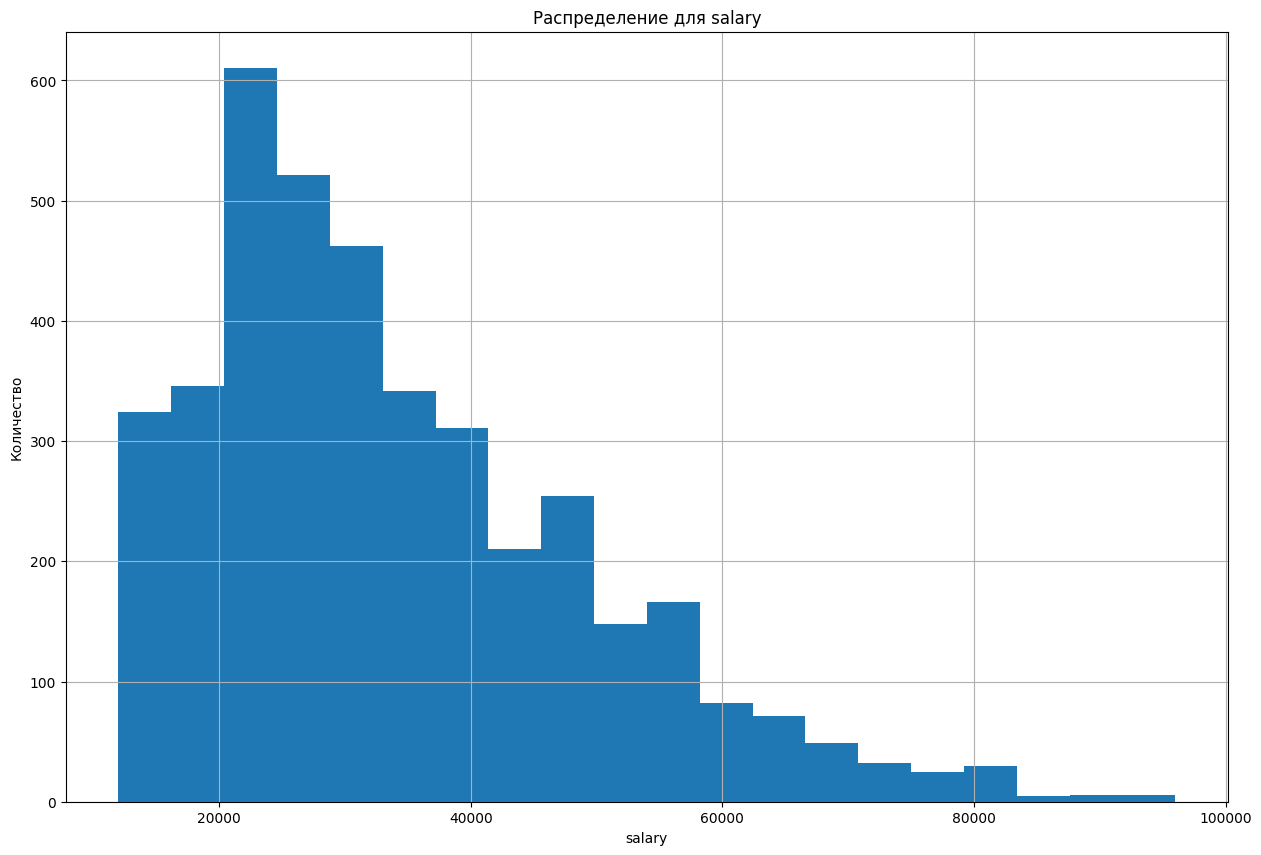

In [62]:
plot_n_describe(train_quit.salary, 'hist')

Уже знакомая картинка, аномалий нет. Обойдёмся без ящика

count     4000
unique       2
top         no
freq      2872
Name: quit, dtype: object

quit
no     71.8
yes    28.2
Name: count, dtype: float64

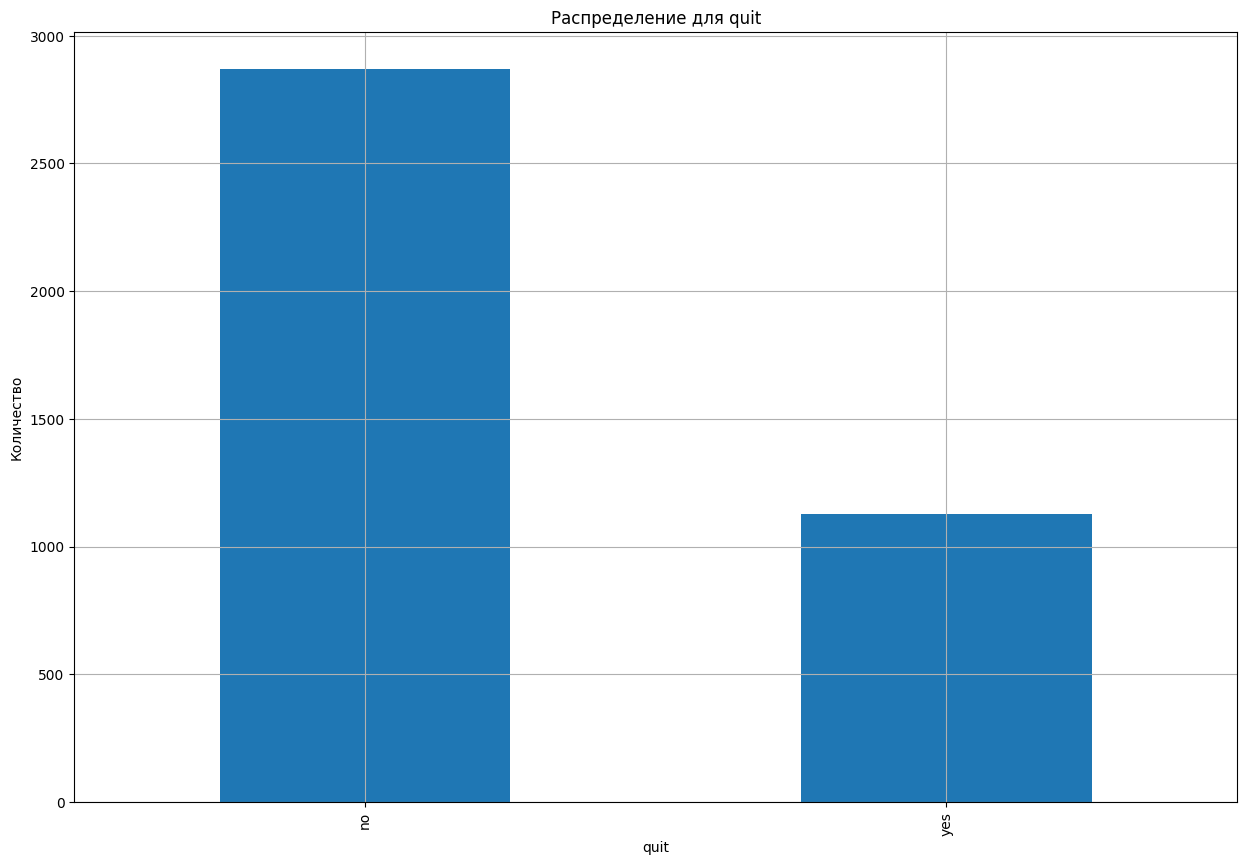

In [63]:
plot_n_describe(train_quit.quit, 'bar')

Целевая переменная, нужна будет кодировка LabelEncoder.

#### test_target_quit

In [64]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


count     2000
unique       2
top         no
freq      1436
Name: quit, dtype: object

quit
no     71.8
yes    28.2
Name: count, dtype: float64

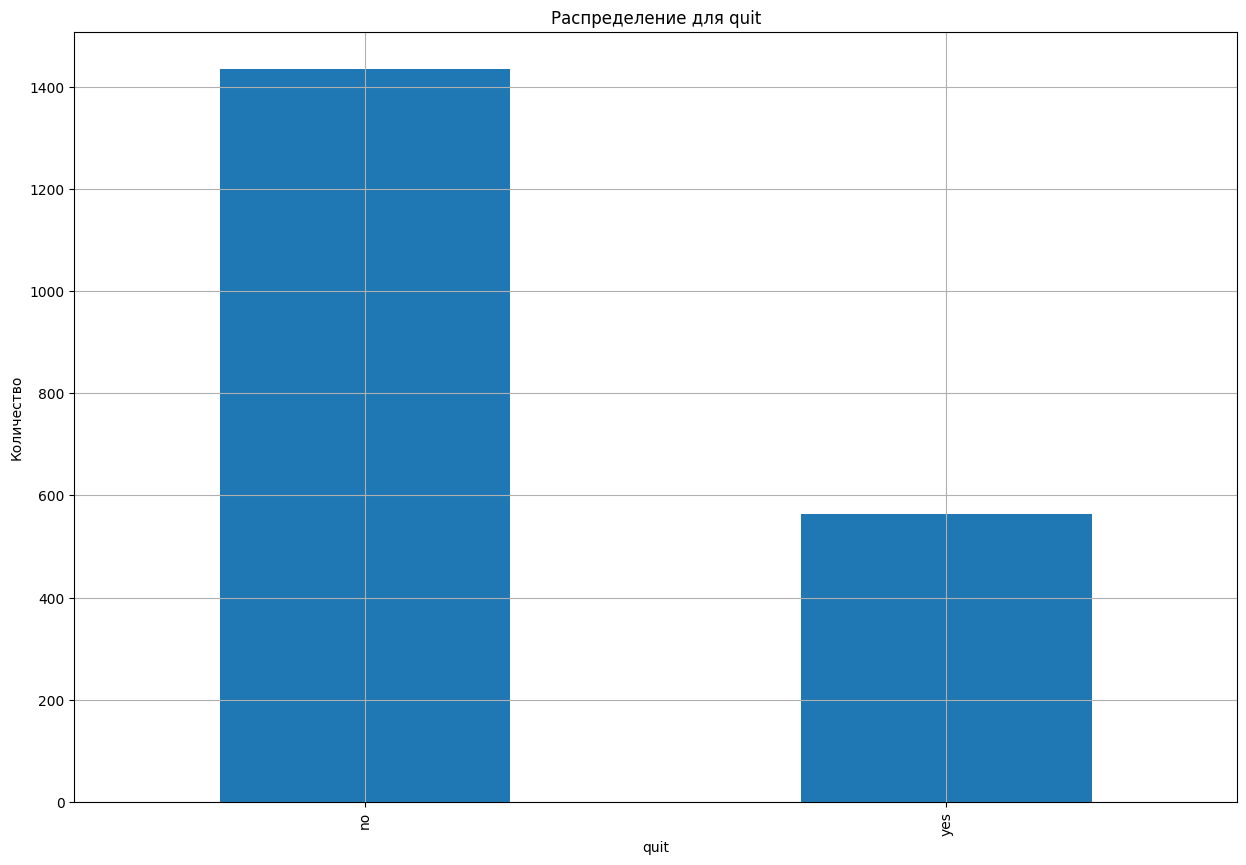

In [65]:
plot_n_describe(test_target_quit.quit, 'bar')

Целевая переменная для теста, опять LabelEncoder.

#### Портрет уволившегося сотрудника

In [66]:
train_quit_yes = train_quit.query('quit == "yes"')

In [67]:
def quit_fraction(x):
    '''
    cчитаем долю уволившихся в %
    '''
    yes = x[x == 'yes'].shape[0]
    total = x.shape[0]
    return 100 * yes / total

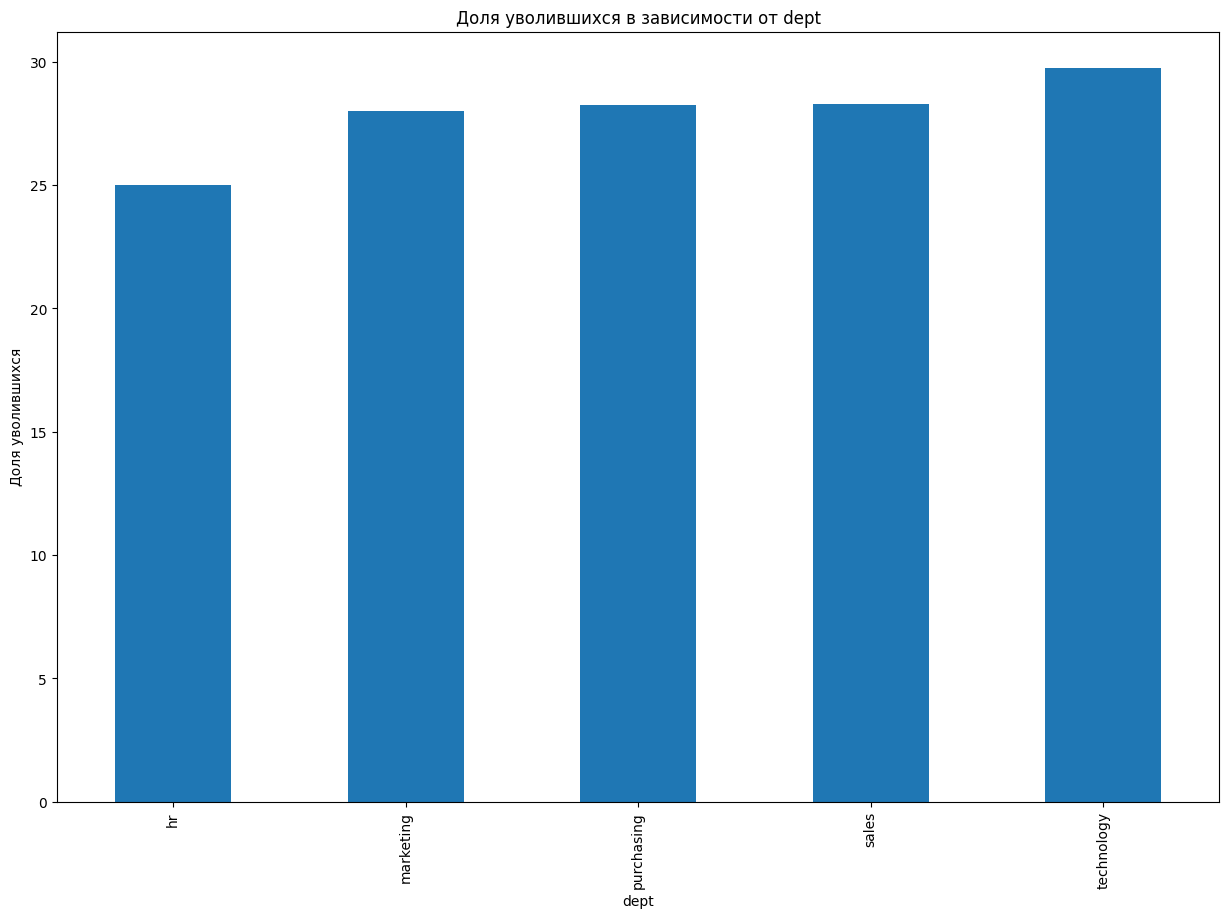

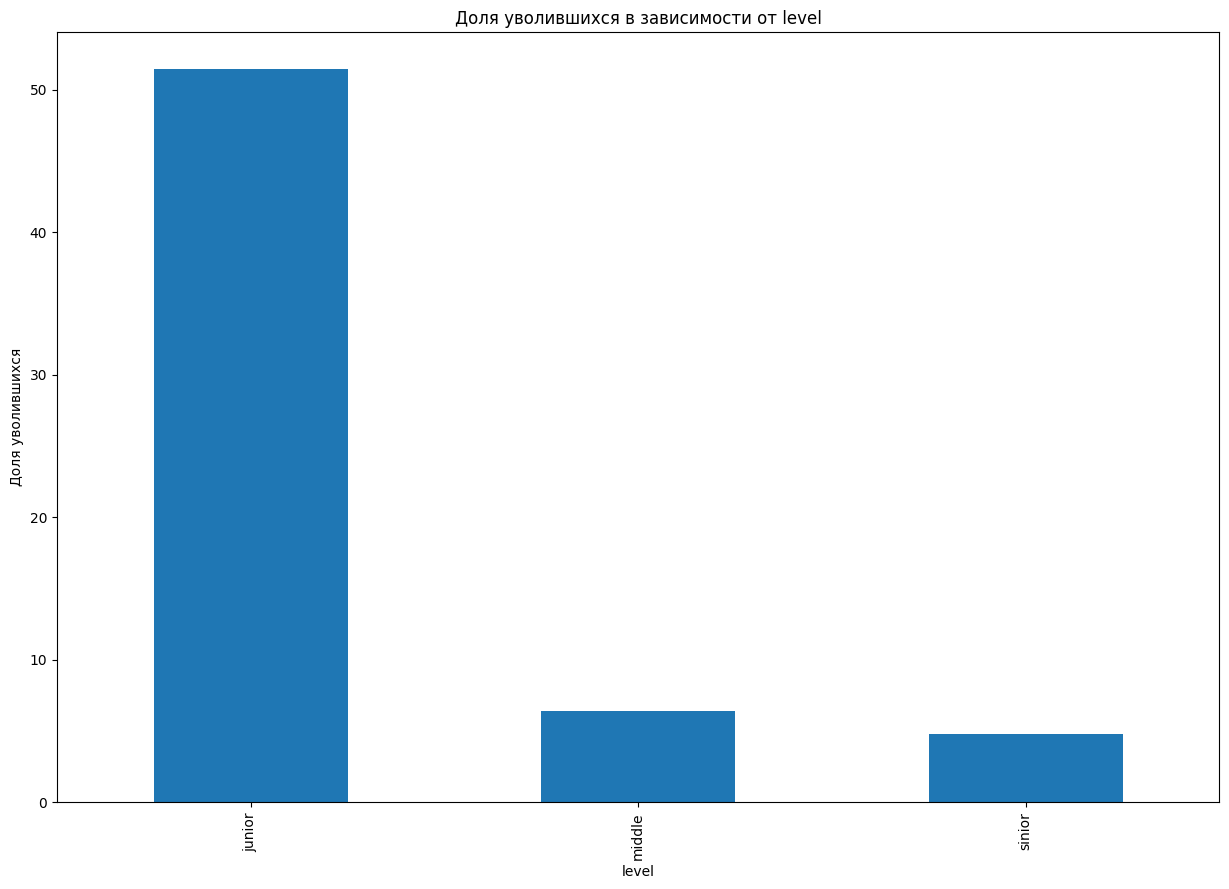

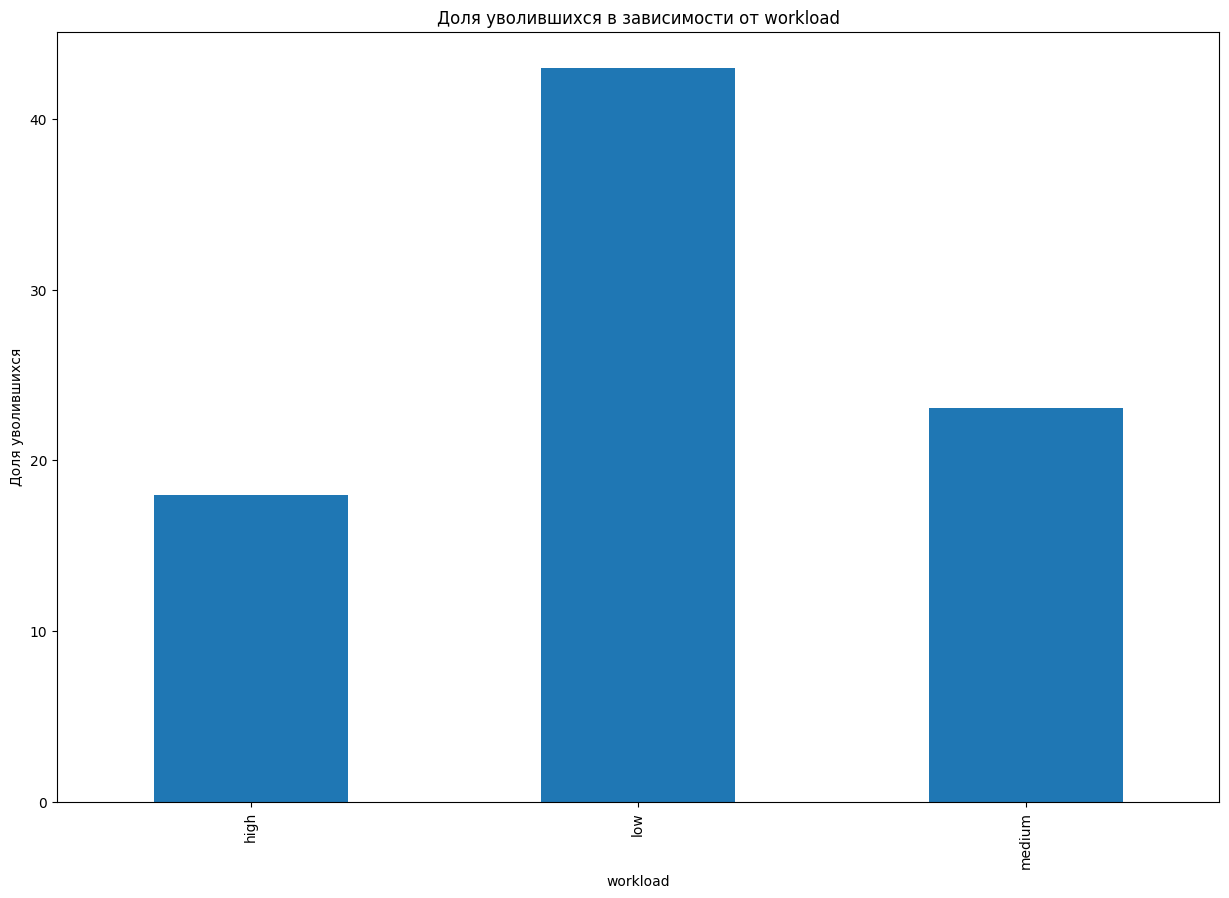

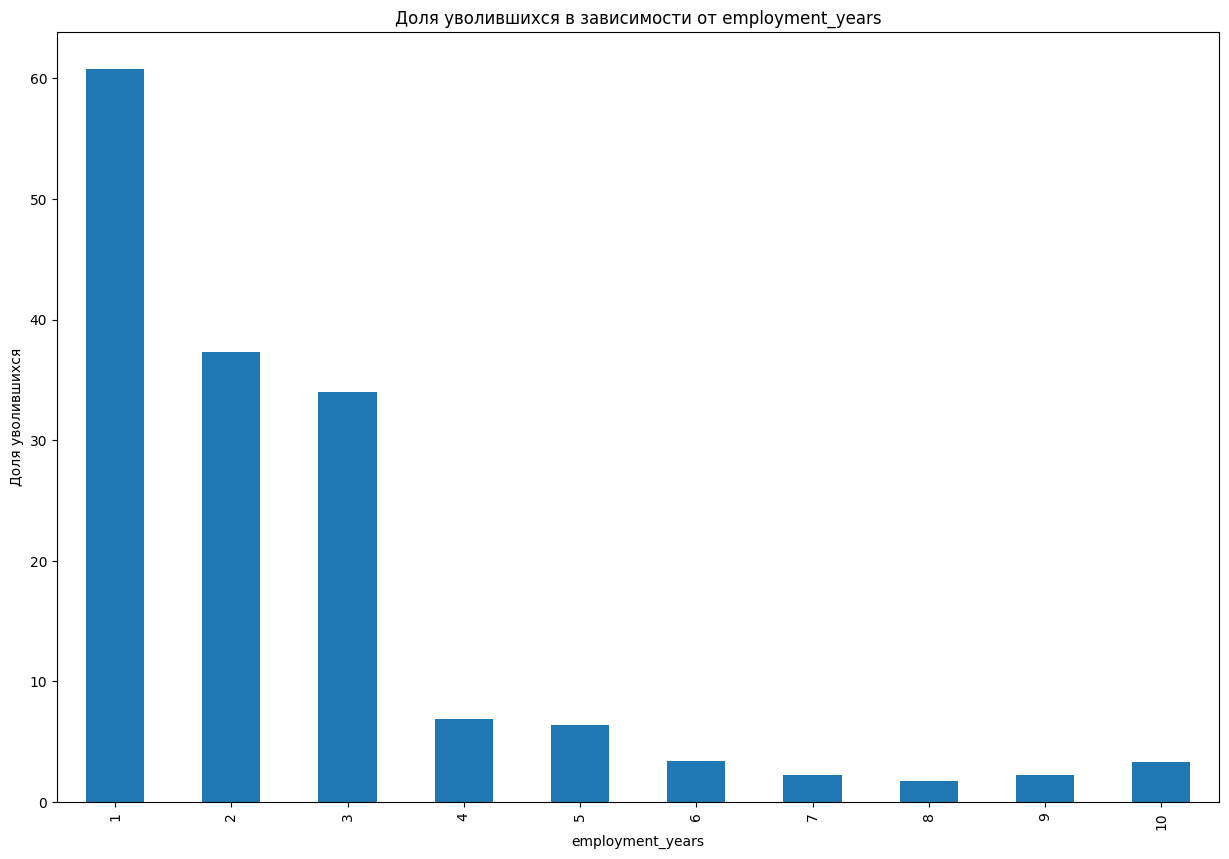

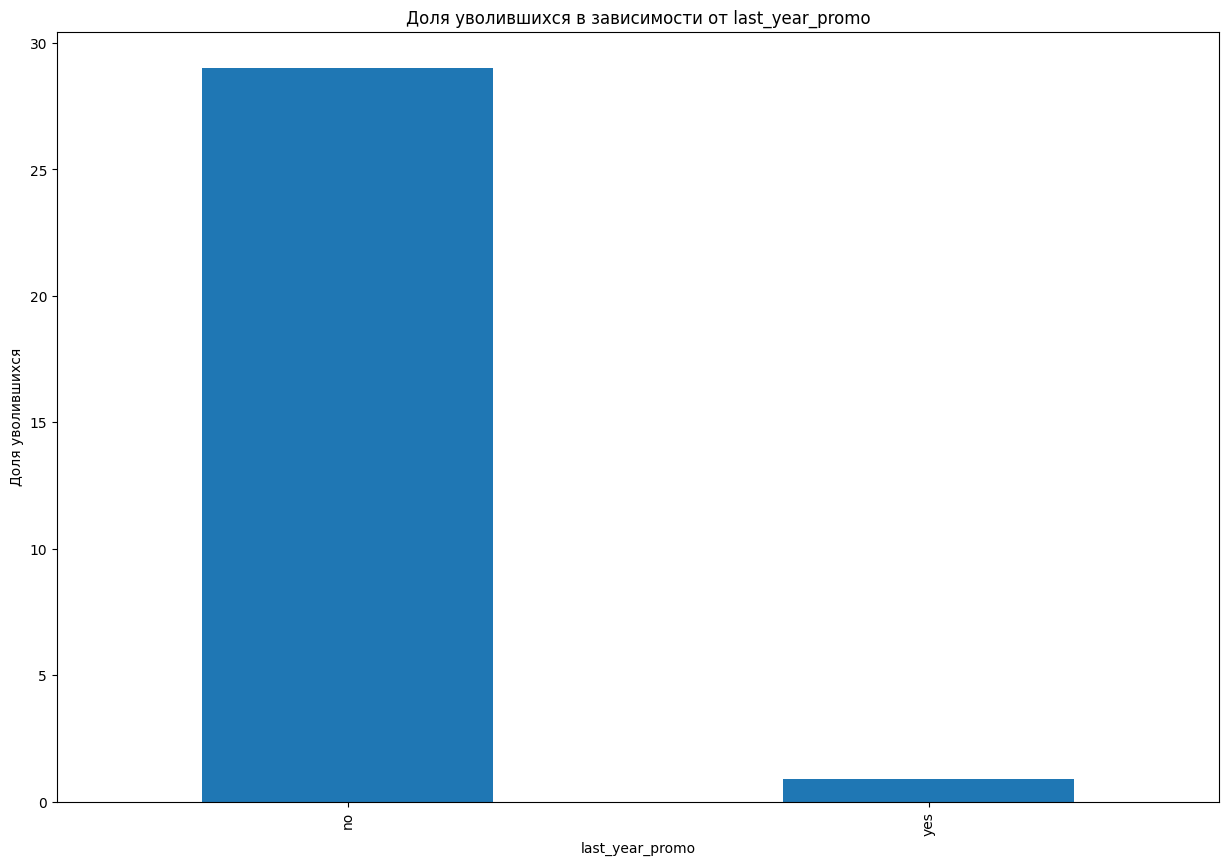

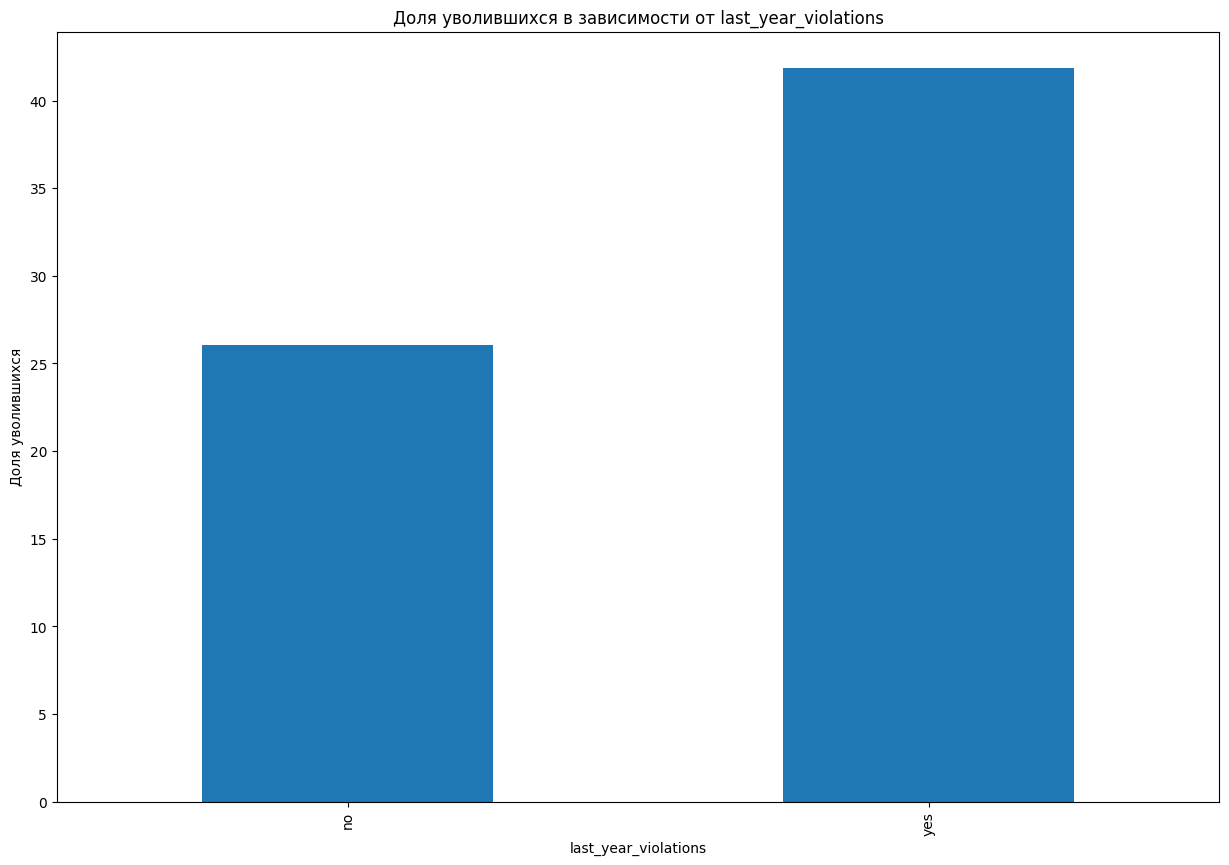

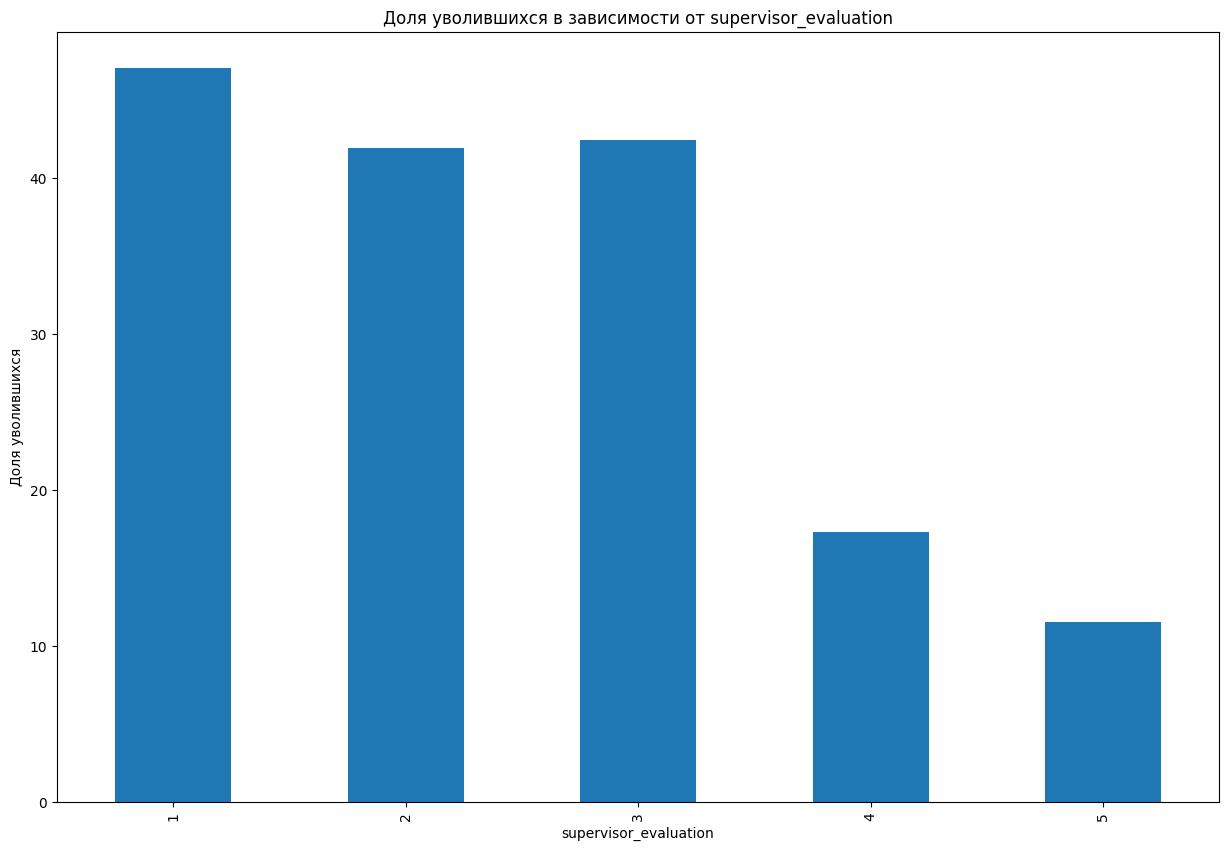

In [68]:
# пройдёмся по кат признакам
for col in [
    'dept', 
    'level', 
    'workload', 
    'employment_years', 
    'last_year_promo', 
    'last_year_violations', 
    'supervisor_evaluation'
]:

    train_quit.groupby(col)['quit'].apply(quit_fraction).plot(kind='bar', figsize=(15,10))

    plt.title(f'Доля уволившихся в зависимости от {col}')
    plt.ylabel('Доля уволившихся')

    plt.show()

Соберём выводы по доли уволившихся:
- от отдела не зависит
- junior уходять в 5-6 раз чаще остальных
- сотрудники с низкой нагрузкой уходят вдвое чаще остальных
- часто уходят в первые 3 года
- получившие повышение практически не увольняются
- после выговора уходят в 1.5 чаще
- сотрудники с оценкой руководителя 4 и 5 уходят в 2-3 раза реже

Таким образом, можно сказать, что чаще всего уволняются в первые 3 года сотрудники уровня junior с низкой нагрузкой и невыской оценкой от руководителя, которые не получали повышения, но получали выговор.

/tmp/ipykernel_70711/3170150635.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_70711/3170150635.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


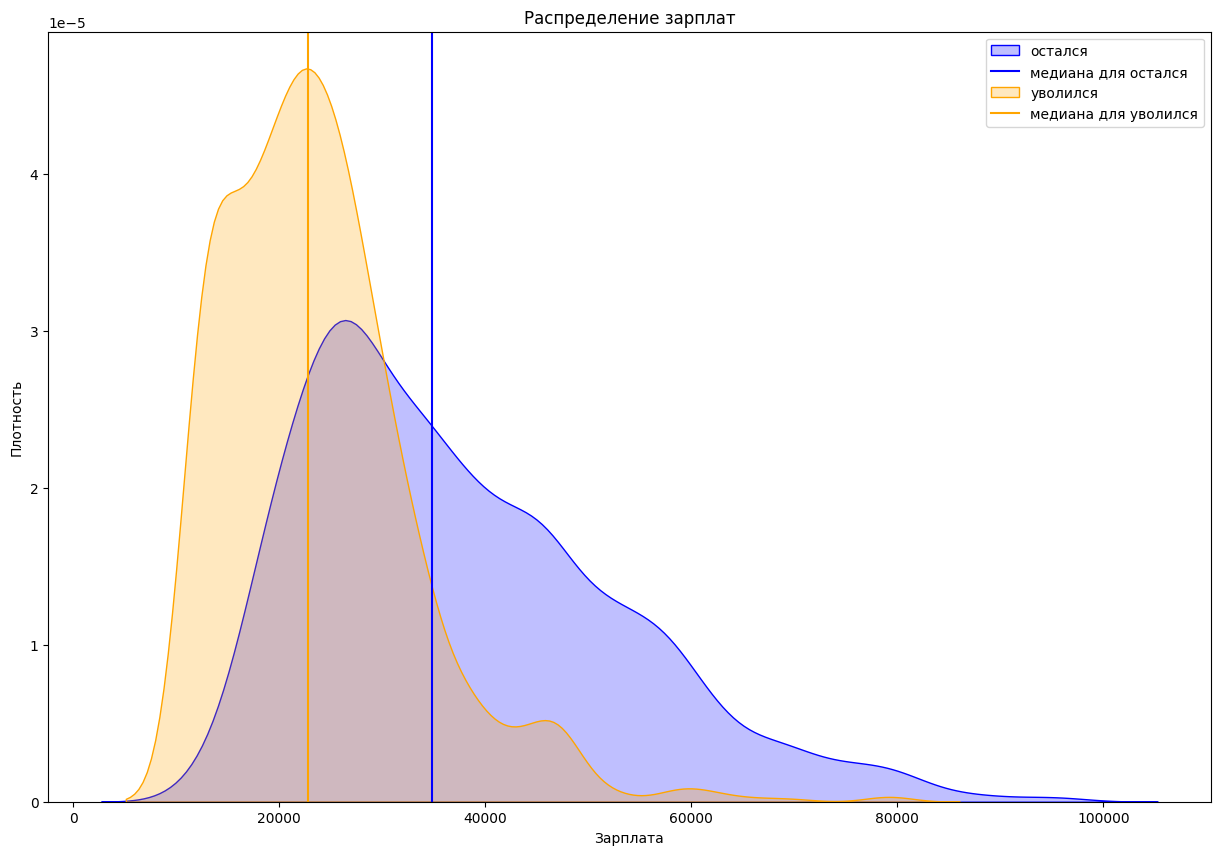

In [69]:
plt.figure(figsize=(15,10))

for key, label, color in [('no', 'остался', 'blue'), ('yes', 'уволился', 'orange')]:
    
    salary = train_quit.query('quit == @key')['salary']
    
    sns.kdeplot(
        salary, 
        label=label,
        shade=True,
        color=color
    )
    
    plt.axvline(
        salary.median(), 
        label=f'медиана для {label}',
        color=color
    )
    
    #plt.axvline(
    #    salary.mean(), 
    #    label=f'среднее для {label}',
    #    color=color,
    #    ls='--'
    #)

plt.title('Распределение зарплат')
plt.xlabel('Зарплата')
plt.ylabel('Плотность')
plt.legend()

plt.show()

У уволившихся сотрудников зарплата в среднем меньше, а распределение сильно уже - люди с заплатой выше 50к почти не увольняются.

#### Связь job_satisfaction_rate и quit

In [70]:
# дф из 1.4.2 = test_features + test_target_job_satisfaction_rate

shape_before = data_test.shape

data_test = data_test.merge(
    test_target_quit,
    on='id'
)

print(shape_before, '+', test_target_quit.shape, '=', data_test.shape)

(2000, 10) + (2000, 2) = (2000, 11)


/tmp/ipykernel_70711/1899669775.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_70711/1899669775.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


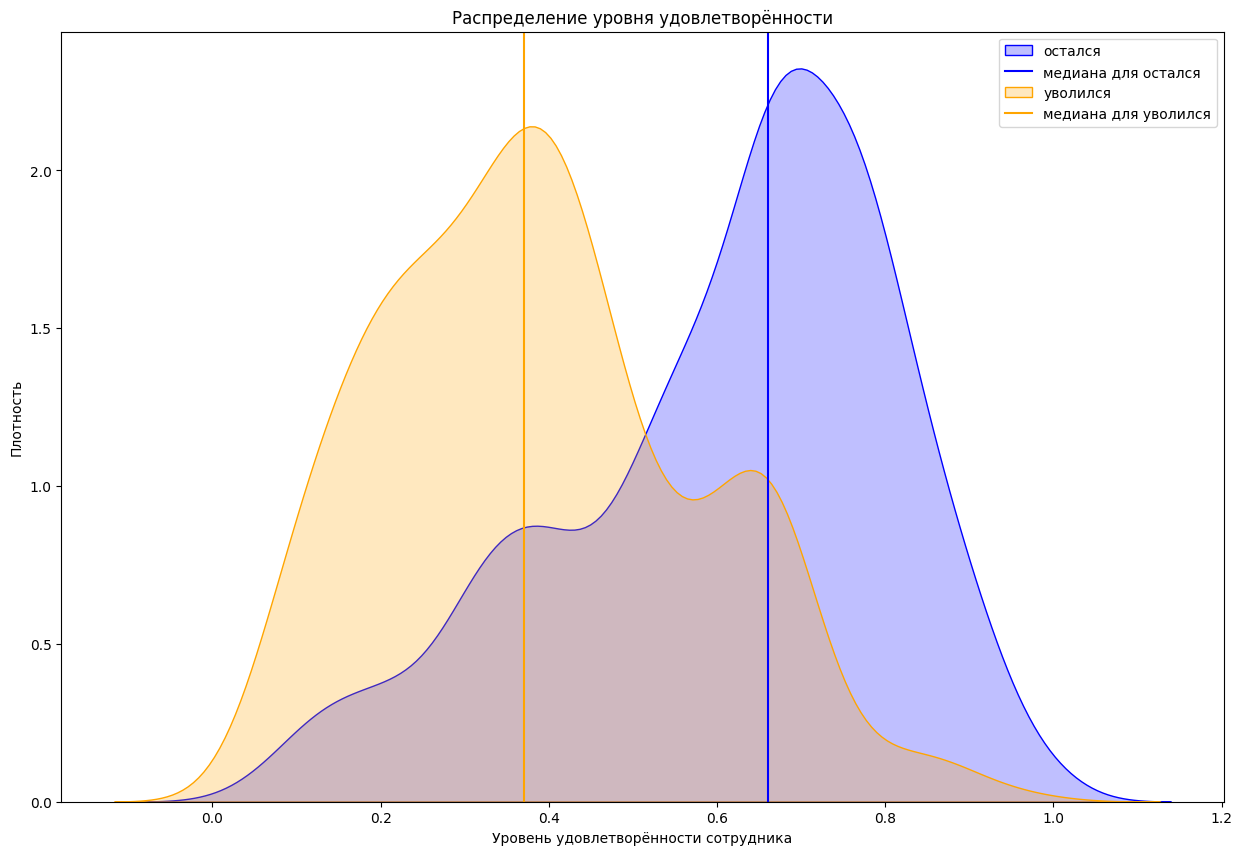

In [71]:
plt.figure(figsize=(15,10))

for key, label, color in [('no', 'остался', 'blue'), ('yes', 'уволился', 'orange')]:
    
    job_satisfaction_rate = data_test.query('quit == @key')['job_satisfaction_rate']
    
    sns.kdeplot(
        job_satisfaction_rate, 
        label=label,
        shade=True,
        color=color
    )
    
    plt.axvline(
        job_satisfaction_rate.median(), 
        label=f'медиана для {label}',
        color=color
    )
    
    #plt.axvline(
    #    job_satisfaction_rate.mean(), 
    #    label=f'среднее для {label}',
    #    color=color,
    #    ls='--'
    #)

plt.title('Распределение уровня удовлетворённости')
plt.xlabel('Уровень удовлетворённости сотрудника')
plt.ylabel('Плотность')
plt.legend()

plt.show()

Связь между увольнением и уровнем удовлетворённости явно прослеживается и по медиане, и по форме распределения.

In [72]:
res = st.ttest_ind(
    data_test.query('quit == "yes"')['job_satisfaction_rate'],
    data_test.query('quit == "no"')['job_satisfaction_rate']
)
res.pvalue

1.2311220665171928e-104

Пусть нулевая гипотеза - равенство уровня удовлетворённости. Из двухстороннего явно видно, вероятность равенства уровня удовлетворённости у тех, кто ушёл, и тех, кто остался, ничтожна.

#### Итог
С данными для обучения и тестирования всё ок. Завимость вероятности увольнения от многих признаков хорошо прослеживается.

### Добавление нового входного признака

In [73]:
train_quit['job_satisfaction_rate'] = grid.predict(
    train_quit.drop(['id', 'quit'], axis=1)
)

train_quit.head()

train_quit,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.601169
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.833855
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.402143
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.334444
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.794667


#### Итог

Добавили предсказания job_satisfaction_rate от лучшей из найденных моделей.

### Подготовка данных

#### Пайплайны

In [74]:
# списки колонок по типу кодировщика

ohe_columns_2 = [
    'dept'
]

ord_columns_2 = [
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations'
]

ord_columns_categories_2 = [
    ['junior', 'middle', 'sinior'],
    ['low', 'medium', 'high'],
    ['no', 'yes'],
    ['no', 'yes']
]

num_columns_2 = [
    'employment_years',
    'supervisor_evaluation',
    'salary',
    'job_satisfaction_rate'
] 

In [75]:
# пайплайны для подготовки

pipe_ohe_2 = pipe_ohe #без изменений

pipe_ord_2 = Pipeline(
    [
        (
            'pipe_ord_imputer',
            SimpleImputer(
                strategy='constant',
                fill_value='unknown'
            )
        ),
        
        (
            'pipe_ord_encoder',
            OrdinalEncoder(
                categories=ord_columns_categories_2,
                handle_unknown='use_encoded_value',
                unknown_value=-1
            )
        )
    ]
)

pipe_num_2 = pipe_num #без изменений

In [76]:
# собираем подготовку в ColumnTransformer

preprocessor_2 = ColumnTransformer(
    [
        ('ohe', pipe_ohe_2, ohe_columns_2),
        
        ('ord', pipe_ord_2, ord_columns_2),
        
        ('num', pipe_num_2, num_columns_2)
    ]
)

In [77]:
# параметры для GridSearchCV

param_grid_2 = [    
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(5, 11) # варьируем максимальную глубину дерева
    },
    
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE)],
        'model__C': np.logspace(-2, 2, 5)  # варьируем силу L2 регуляризации
    },
    
    {
        'model': [SVC(random_state=RANDOM_STATE, probability=True)],
        'model__kernel': ['linear', 'poly', 'rbf'] # варьируем тип ядра
    }
]

In [78]:
# итоговый пайплайн, без модели по умолчанию

pipe_final_2 = Pipeline(
    [        
        (
            'preproccessor', 
            preprocessor_2
        ),
        
        (
            'model', 
            None
        )
    ]
) 

#### Данные

In [79]:
# train
X_train_2 = train_quit.drop(['id', 'quit'], axis=1)
le = LabelEncoder()
y_train_2 = le.fit_transform(train_quit['quit'])

# инверсия при необходимости
if le.classes_[0] == 'yes':
    y_train_2 = 1 - y_train_2

In [80]:
# test
X_test_2 = data_test.drop(['id', 'quit'], axis=1)
y_test_2 = le.transform(data_test['quit'])

# инверсия при необходимости
if le.classes_[0] == 'yes':
    y_test_2 = 1 - y_test_2

### Обучение модели

#### Обучение

In [81]:
grid_2 = GridSearchCV(
    pipe_final_2, 
    param_grid_2, 
    cv=5,
    scoring='roc_auc', 
    n_jobs=-1
)

In [82]:
%%time
grid_2.fit(X_train_2, y_train_2)

CPU times: user 643 ms, sys: 12.3 ms, total: 655 ms
Wall time: 1.76 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproccessor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         Pipeline(steps=[('pipe_ohe_imputer',
                                                                                          SimpleImputer(fill_value='unknown',
                                                                                                        strategy='constant')),
                                                                                         ('pipe_ohe_encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('pipe_ord_imputer',
                                                                                          SimpleImp...
                                                                          'job_satisfaction_rate'])])),
                                       ('model', None)]),
             n_jobs=-1,
             param_grid=[{'model': [DecisionTreeClassifier(random_state=42)],
                          'model__max_depth': range(5, 11)},
                         {'model': [LogisticRegression(random_state=42)],
                          'model__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
                         {'model': [SVC(probability=True, random_state=42)],
                          'model__kernel': ['linear', 'poly', 'rbf']}],
             scoring='roc_auc')

In [83]:
pd.DataFrame(grid_2.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_depth,param_model__C,param_model__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,0.392786,0.080905,0.017456,0.000632,"SVC(probability=True, random_state=42)",NaN,NaN,poly,"{'model': SVC(probability=True, random_state=4...",0.921702,0.934343,0.919900,0.928793,0.936915,0.928331,0.006709,1
13,0.589012,0.126462,0.026344,0.000181,"SVC(probability=True, random_state=42)",NaN,NaN,rbf,"{'model': SVC(probability=True, random_state=4...",0.916011,0.928040,0.923810,0.929360,0.941154,0.927675,0.008193,2
1,0.022958,0.003701,0.010083,0.000559,DecisionTreeClassifier(random_state=42),6.0,NaN,NaN,{'model': DecisionTreeClassifier(random_state=...,0.923354,0.930546,0.921618,0.912186,0.942782,0.926097,0.010191,3
0,0.016505,0.002450,0.010042,0.001072,DecisionTreeClassifier(random_state=42),5.0,NaN,NaN,{'model': DecisionTreeClassifier(random_state=...,0.916493,0.920805,0.923946,0.913262,0.934555,0.921812,0.007339,4
9,0.026180,0.000209,0.011175,0.000550,LogisticRegression(random_state=42),NaN,10.00,NaN,"{'model': LogisticRegression(random_state=42),...",0.923347,0.913460,0.912020,0.911752,0.925994,0.917315,0.006092,5
10,0.025995,0.001398,0.010709,0.000618,LogisticRegression(random_state=42),NaN,100.00,NaN,"{'model': LogisticRegression(random_state=42),...",0.923449,0.913497,0.912090,0.911839,0.925460,0.917267,0.005930,6
8,0.024604,0.001350,0.010997,0.000109,LogisticRegression(random_state=42),NaN,1.00,NaN,"{'model': LogisticRegression(random_state=42),...",0.922770,0.913475,0.911919,0.911469,0.926320,0.917190,0.006145,7
7,0.023632,0.000254,0.010361,0.000861,LogisticRegression(random_state=42),NaN,0.10,NaN,"{'model': LogisticRegression(random_state=42),...",0.921394,0.913651,0.912152,0.911579,0.926444,0.917044,0.005875,8
2,0.021008,0.001137,0.009492,0.001073,DecisionTreeClassifier(random_state=42),7.0,NaN,NaN,{'model': DecisionTreeClassifier(random_state=...,0.906775,0.932942,0.912941,0.912351,0.920077,0.917017,0.009014,9
6,0.021229,0.000854,0.010468,0.000974,LogisticRegression(random_state=42),NaN,0.01,NaN,"{'model': LogisticRegression(random_state=42),...",0.917292,0.912418,0.911996,0.911161,0.924855,0.915545,0.005125,10


In [84]:
roc_auc_test_2 = grid_2.score(X_test_2, y_test_2)
print(f'ROC-AUC для тестовой: {roc_auc_test_2:.3f}')

ROC-AUC для тестовой: 0.923


/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


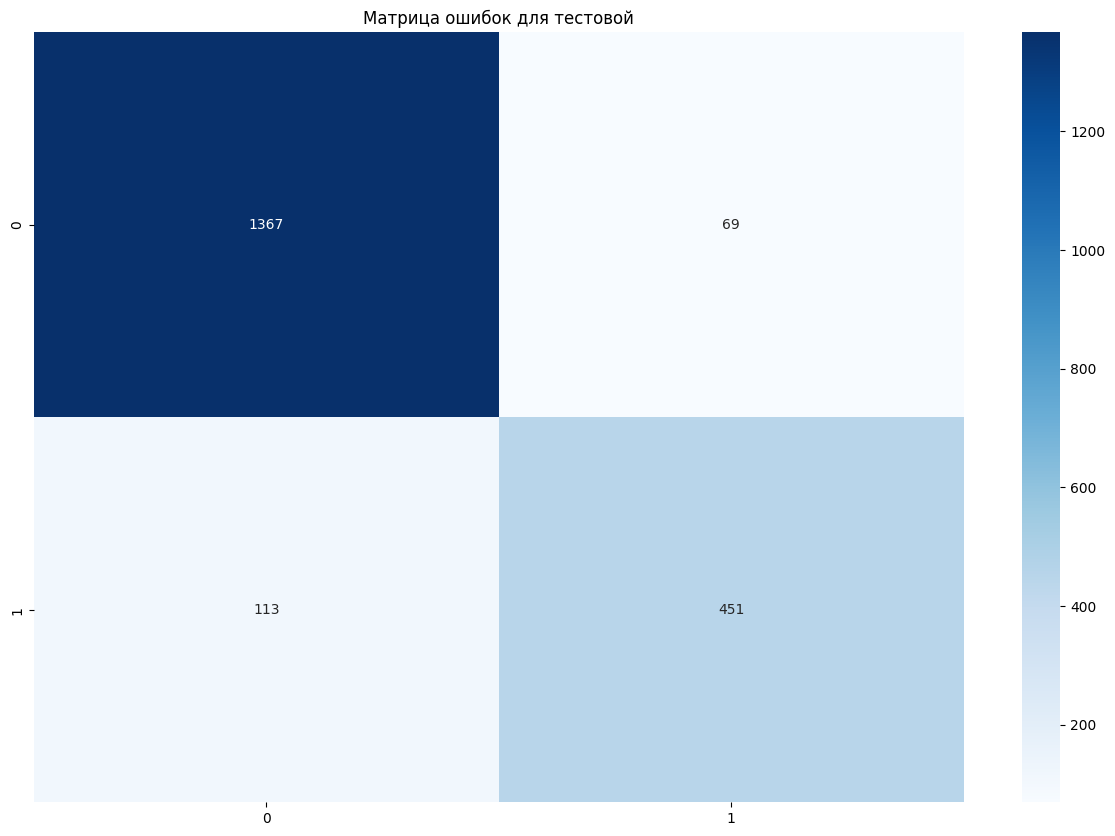

In [85]:
y_test_2_pred = grid_2.predict(X_test_2)

plt.figure(figsize=(15, 10))
sns.heatmap(
    confusion_matrix(y_test_2, y_test_2_pred),
    annot=True, 
    cmap='Blues',
    fmt = '.0f'
)
plt.title('Матрица ошибок для тестовой')
plt.show()

/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  0%|          | 0/2000 [00:00<?, ?it/s]

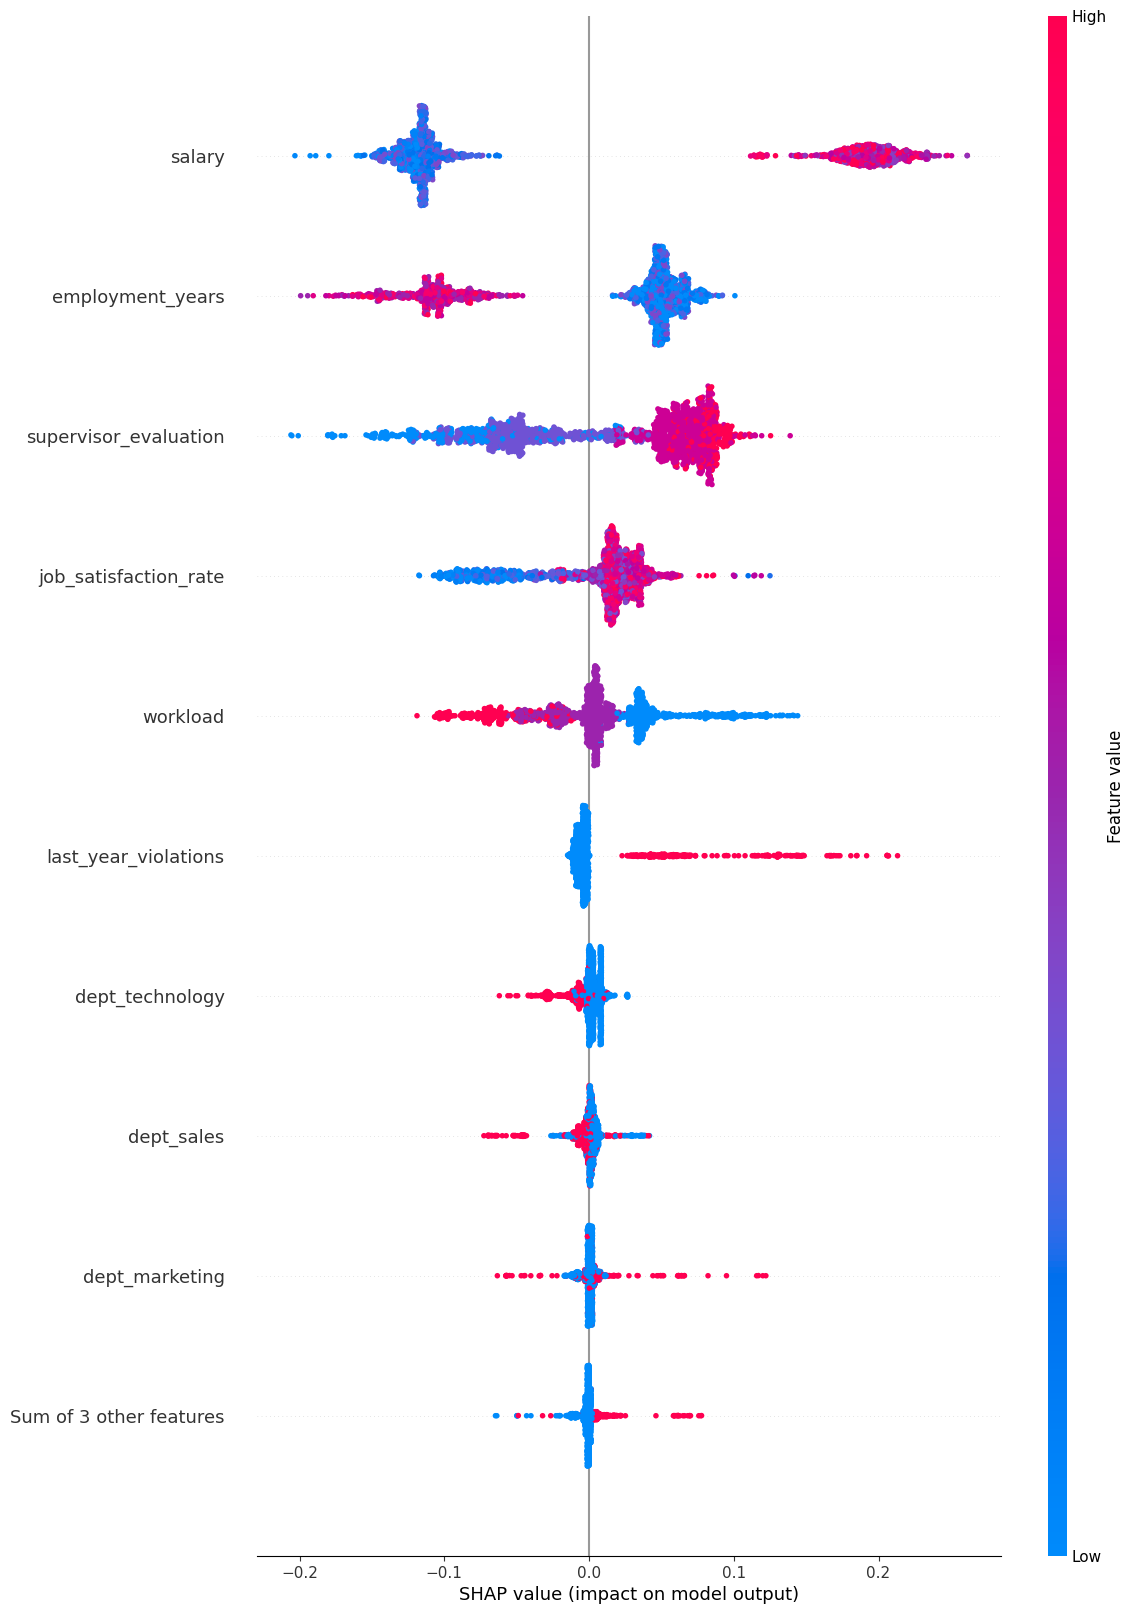

CPU times: user 14min, sys: 2min 1s, total: 16min 2s
Wall time: 13min 36s


In [87]:
%%time

X_test_scaled = grid_2.best_estimator_.named_steps['preproccessor'].transform(X_test_2)

features = [name.split('__')[1] \
            for name in grid_2.best_estimator_.named_steps['preproccessor'].get_feature_names_out()]

X_test_scaled = pd.DataFrame(data=X_test_scaled, columns=features)

explainer = shap.KernelExplainer(
    grid.best_estimator_.named_steps['model'].predict, 
    shap.sample(X_test_scaled, 100)
)

shap_values = explainer(
    X_test_scaled
)

shap.plots.beeswarm(shap_values, plot_size=(12, 20))

#### Итог

Лучше всего показал себя метод опорных векторов с полиномильным ядром.
Важно отметить, что эта модель с другими ядрами, а также другие модели с различными гиперпараметрами обеспечили близкие результаты - разброс для ROC-AUC от 0.898 до 0.928

При проверке модели на тестовых данных метрика получилась 0.923. То есть качество модели практически идентично на обучающей и тестовой выборке. Это снова позволяет сказать, что переобучения нет.

### Промежуточные выводы

(текст из 1.6, ибо получилось идентично)

- При загрузке данных проблем не было, предобработка и исследовательский анализ также критических проблем не выявили.

- Обработка пропусков и кодирование были полностью сделаны в пайплайне, устойчивость к новым значениям категориальных признаков проверена

- С использованием GridSearchCV была найдена лучшая модель и её гиперпараметры. В качестве метрики была использована ROC-AUC.

- При проверке на тестовых данных модель показала качество, практически идентичное результатам на обучающей.

- Видно, что сейчас модель чаще выдает FN, чем FP

## Общие выводы

Задача проекта - научиться прогнозировать две важных для бизнеса велчины:
1. уровень удовлетворённости сотрудника
1. вероятность увольнения сотрудника из компании
Величины смело можно считать связанными - удовлетворённость работой напрямую влияет на отток сотрудников.
Поэтому при прогнозировании второй очень полезна информация о первой (априорная или спрогнозированная).

Глобально у работы 2 этапа:
1. построение модели для предсказания уровня удовлетворённости сотрудника
2. построение модели для предсказания вероятности увольнения сотрудника из компании с использованием результатов моели из этапа 1

Каждые из этапов включает в себя стандартные шаги:
- загрузка данных
- предобработка данных
- исследовательский анализ данных
- подготовка пайплайна и данных
- обучение и тестирование модели

На каждом из этапов удалось получить модели, работающую адекватно как на обучающей, так и не тестовой выборках.
Опираясь на портрет увольняющегося (см. 2.3.3), можно порекомендовать компании обратить внимание на низконагруженных сотрудников, работающих 1-2-3 года и имеющих невысокие оценки руководителя.
Можно, например, им увеличить нагрузку и приставить более опытного сотрудника в качестве наставника, что может помочь таким сотрудниками повысить квалификацию, заинтересованность, а также оценки руководителя.
Также можно было бы оценить важность признаков (например, силами SHAP) и посмотреть, что сильнее всего влияет на целевые переменные. 
Особенно это было полезно на срезе middle и sinior, так как эти сотрудники занимаются ключевыми задачами, и их внезапное увольнение можно создать большие проблемы.
Понимание и коррекция (по возможности) нужных признаков позволили бы этого избежать.